<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/PCPatientModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION

1. Loading data...
   Loaded 8121 samples with 106 features
DATA DIAGNOSIS
✓ VISDAY: Found (8056 non-NA values)
✓ os_event: Found (8121 non-NA values)
✓ DSDAY: Found (1265 non-NA values)
✓ RPT: Found (8121 non-NA values)

Total records: 8121
Unique patients (RPT): 526

os_event distribution:
  os_event = 0: 7023 records
  os_event = 1: 1098 records
  Missing os_event: 0 records

Patients who die (os_event=1):
  Count: 76

Sample patient 4 (who dies):
    VISDAY  DSDAY  os_event
76     0.0  309.0         1
78     8.0  309.0         1
69    16.0  309.0         1
70    29.0  309.0         1
71    38.0  309.0         1
72    58.0  309.0         1
77    79.0  309.0         1
73   155.0  309.0         1
74   239.0  309.0         1
75   309.0  309.0         1
  Unique DSDAY values: 1 (non-NA: 1)
  Death day: 309.0

VISDAY vs DSDAY analysis:
  Visits after death (VISDAY > DSDAY): 10
  Visits on death day (VISDAY == DSDAY): 77
  Visits bef

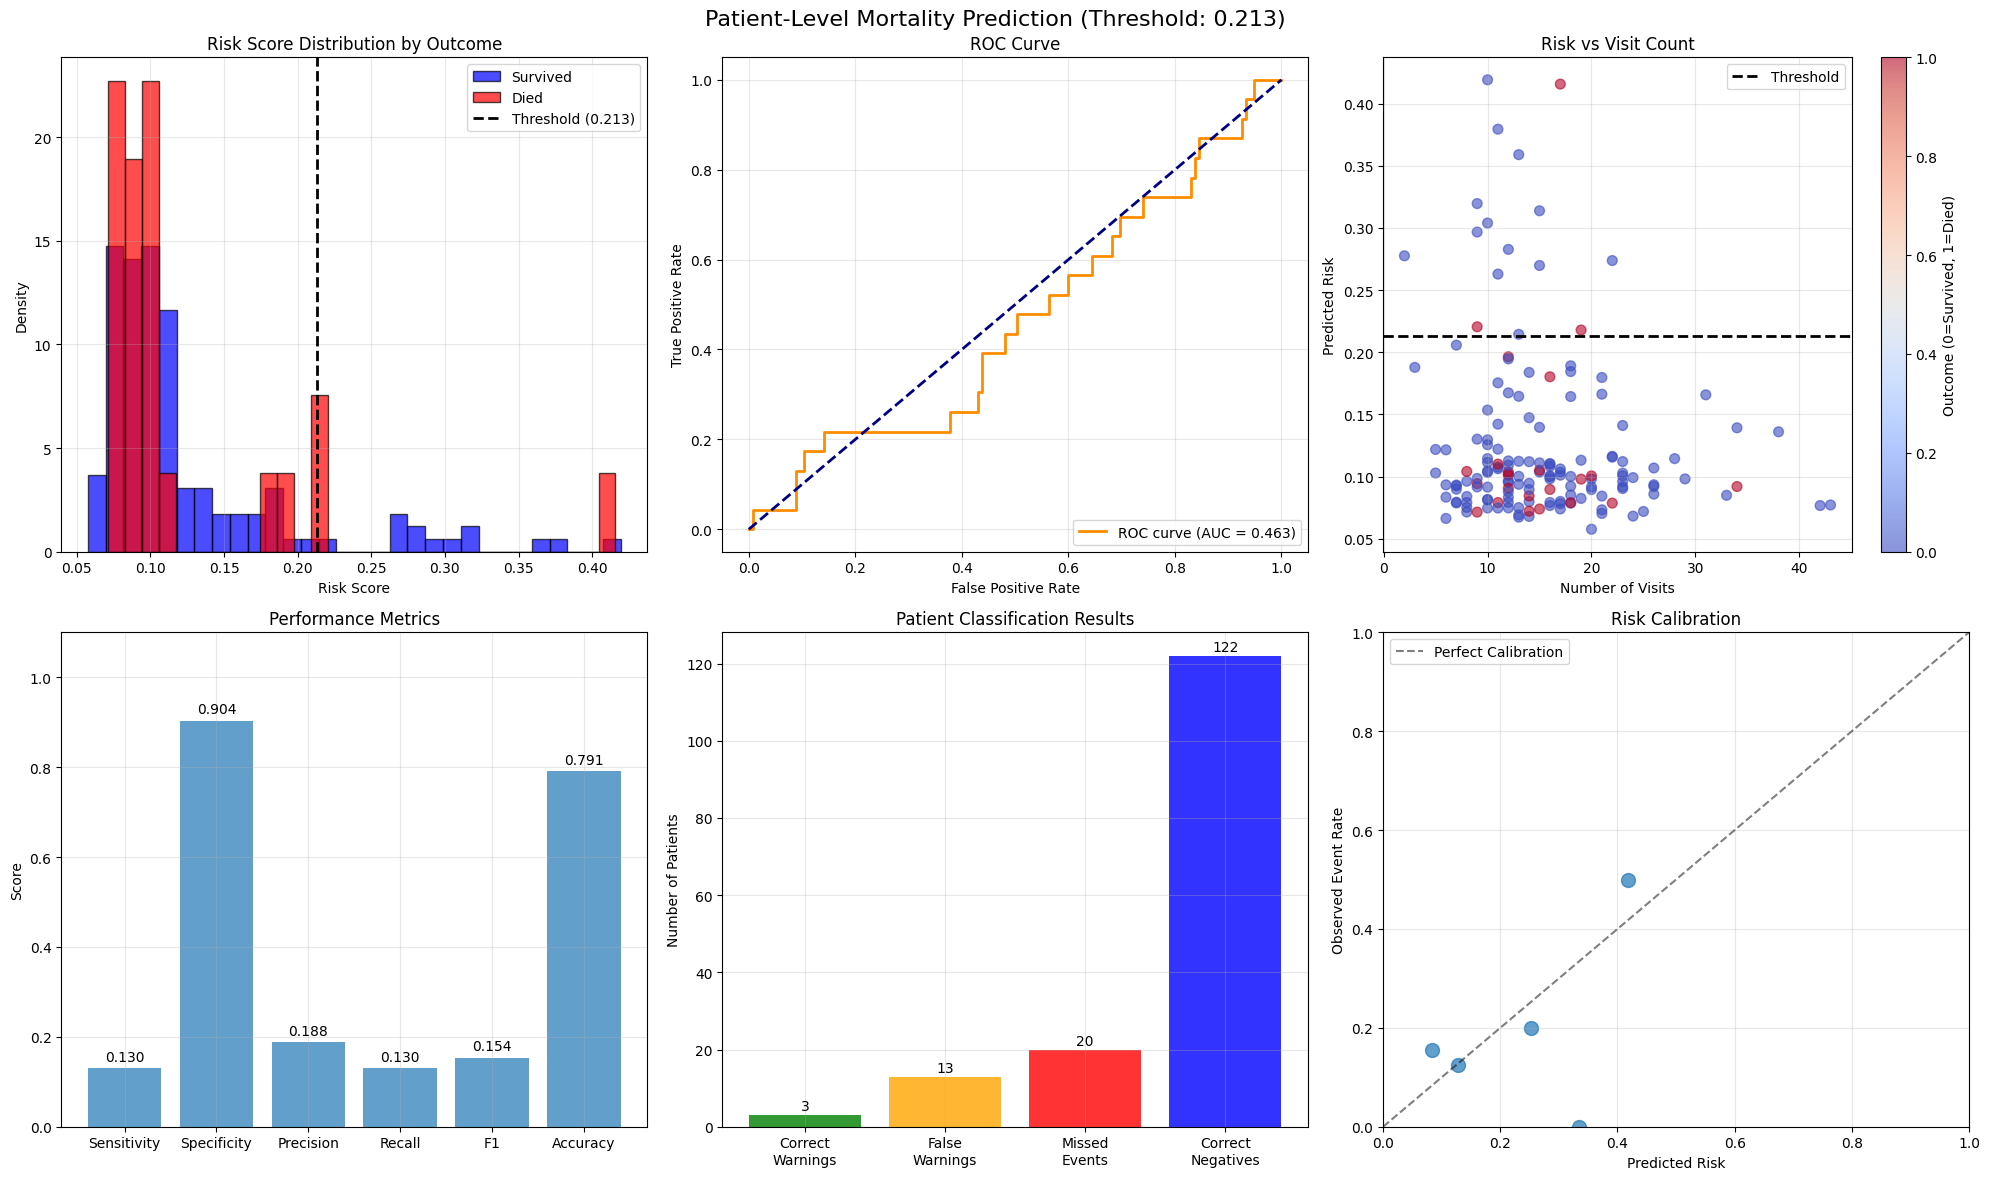


9. Making final predictions on all patients...
Using autoencoder imputation: True
Using 31 available features
Categorical columns: 0
Numeric columns: 31
Train data shape before imputation: (1470, 31)
Test data shape before imputation: (2630, 31)
Missing values in train: 868 (1.9%)
Missing values in test: 1547 (1.9%)

Fitting autoencoder on training data...
Autoencoder trained on 681 complete cases
Imputing missing values in training set...
Autoencoder imputation converged after 5 iterations
Imputing missing values in test set...
Autoencoder imputation converged after 5 iterations
Missing values after autoencoder imputation (train): 0
Missing values after autoencoder imputation (test): 0
Error: cannot reshape array of size 1160330 into shape (526,5,31)


Traceback (most recent call last):
  File "/tmp/ipython-input-927608745.py", line 1858, in run_clinical_early_warning
    results = warning_pipeline.run_patient_level_pipeline(pcdata)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-927608745.py", line 1509, in run_patient_level_pipeline
    all_imputed = all_imputed_flat.reshape(n_all_samples, seq_len, n_features)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: cannot reshape array of size 1160330 into shape (526,5,31)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

class AutoencoderImputer:
    def __init__(self, encoding_dim=32, epochs=50, batch_size=32, random_state=42):
        self.encoding_dim = encoding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.is_fitted = False

    def build_autoencoder(self, input_dim):
        """Build a deep autoencoder for imputation"""
        input_layer = layers.Input(shape=(input_dim,))

        # Encoder
        encoded = layers.Dense(128, activation='relu')(input_layer)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(self.encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(input_dim, activation='linear')(decoded)

        # Autoencoder model
        autoencoder = models.Model(input_layer, decoded)

        # Encoder model (for feature extraction)
        encoder = models.Model(input_layer, encoded)

        autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                           loss='mse',
                           metrics=['mae'])

        return autoencoder, encoder

    def fit_imputer(self, X_train):
        """Train autoencoder on complete data"""
        # Create mask for complete cases
        complete_mask = ~np.any(np.isnan(X_train), axis=1)
        X_complete = X_train[complete_mask]

        if len(X_complete) < 10:
            print(f"Warning: Only {len(X_complete)} complete cases for autoencoder training")
            return self

        # Scale the data
        X_scaled = self.scaler.fit_transform(X_complete)

        # Build and train autoencoder
        self.autoencoder, self.encoder = self.build_autoencoder(X_scaled.shape[1])

        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        # Train-validation split
        X_train_split, X_val_split = train_test_split(
            X_scaled, test_size=0.2, random_state=self.random_state
        )

        self.autoencoder.fit(
            X_train_split, X_train_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(X_val_split, X_val_split),
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        self.is_fitted = True
        print(f"Autoencoder trained on {len(X_complete)} complete cases")

        return self

    def impute_missing_values(self, X, max_iter=20, tol=1e-4):
        """Impute missing values using trained autoencoder with iterative refinement"""
        if not self.is_fitted:
            print("Autoencoder not fitted. Fitting now...")
            self.fit_imputer(X)
            if not self.is_fitted:
                return X  # Return original if still not fitted

        X_imputed = X.copy()

        # Check for missing values
        if not np.any(np.isnan(X_imputed)):
            return X_imputed

        # Initial imputation with median
        for i in range(X_imputed.shape[1]):
            col_data = X_imputed[:, i]
            if np.any(np.isnan(col_data)):
                median_val = np.nanmedian(col_data)
                if np.isnan(median_val):
                    median_val = 0
                col_data[np.isnan(col_data)] = median_val
                X_imputed[:, i] = col_data

        # Iterative refinement
        for iteration in range(max_iter):
            X_old = X_imputed.copy()

            # Scale
            X_scaled = self.scaler.transform(X_imputed)

            # Get reconstructions
            X_reconstructed = self.autoencoder.predict(X_scaled, verbose=0)
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)

            # Only update missing values
            missing_mask = np.isnan(X)
            X_imputed[missing_mask] = X_reconstructed[missing_mask]

            # Check convergence
            if iteration > 0:
                change = np.linalg.norm(X_imputed - X_old) / np.linalg.norm(X_old)
                if change < tol:
                    print(f"Autoencoder imputation converged after {iteration+1} iterations")
                    break

        return X_imputed

class RobustTimeAwareDataProcessor:
    def __init__(self, use_autoencoder=True):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.use_autoencoder = use_autoencoder
        self.autoencoder_imputer = AutoencoderImputer() if use_autoencoder else None
        self.feature_names = None

    def clean_data(self, df):
        """Clean data by handling infinity, large values, and missing data"""
        df_clean = df.copy()

        # Replace infinity with NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        # Handle extremely large values by capping at 99th percentile
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].notna().any():
                # Cap at 99th percentile
                p99 = df_clean[col].quantile(0.99)
                if not np.isnan(p99):
                    df_clean[col] = df_clean[col].clip(upper=p99 * 10)  # Allow some margin

        return df_clean

    def process_patient_data(self, df):
        """Process data with proper temporal structure using DSDAY for death timing"""
        # Clean data first
        df_clean = self.clean_data(df)

        # Handle missing survival data
        missing_before = len(df_clean)
        df_clean = df_clean.dropna(subset=['VISDAY'])
        missing_after = len(df_clean)
        print(f"Removed {missing_before - missing_after} rows with missing VISDAY")

        # Check for required columns
        if 'DSDAY' not in df_clean.columns:
            print("ERROR: DSDAY column not found. This is required for death timing.")
            print("Available columns:", df_clean.columns.tolist())
            return None

        # Create patient IDs
        if 'RPT' in df_clean.columns:
            df_clean['patient_id'] = df_clean['RPT']
            print(f"Using 'RPT' as patient identifier")
        elif 'patient_id' not in df_clean.columns:
            possible_id_cols = ['SUBJID', 'PATIENT', 'patient', 'id', 'ID']
            for col in possible_id_cols:
                if col in df_clean.columns:
                    df_clean['patient_id'] = df_clean[col]
                    print(f"Using '{col}' as patient identifier")
                    break

        # Sort by patient and visit day
        df_sorted = df_clean.sort_values(['patient_id', 'VISDAY']).reset_index(drop=True)

        # DEBUG: Check data structure
        print(f"\nDEBUG: Checking first few rows...")
        print(df_sorted[['patient_id', 'VISDAY', 'DSDAY', 'os_event']].head(10))

        # Calculate time to event for each visit
        print("\nCalculating time-to-event for each visit...")
        df_sorted['time_to_event'] = np.nan
        df_sorted['is_future_event'] = 0

        unique_patients = df_sorted['patient_id'].unique()
        print(f"Processing {len(unique_patients)} patients...")

        for i, pid in enumerate(unique_patients):
            if i % 200 == 0:
                print(f"  Processed {i}/{len(unique_patients)} patients...")

            patient_data = df_sorted[df_sorted['patient_id'] == pid].copy()

            # DEBUG for first few patients
            if i < 10:
                print(f"\nDEBUG Patient {pid}:")
                print(f"  Total visits: {len(patient_data)}")
                print(f"  os_event values: {patient_data['os_event'].unique()}")
                print(f"  VISDAY range: {patient_data['VISDAY'].min()} to {patient_data['VISDAY'].max()}")
                print(f"  DSDAY values: {patient_data['DSDAY'].unique()}")
                print(f"  Non-NA DSDAY count: {patient_data['DSDAY'].notna().sum()}")

            # Check if patient died (has os_event = 1 AND has DSDAY)
            patient_events = patient_data['os_event'].values
            patient_dsdays = patient_data['DSDAY'].values

            # Find non-NaN DSDAY values for this patient
            valid_dsday_mask = ~pd.isna(patient_dsdays)

            if np.any(patient_events == 1) and np.any(valid_dsday_mask):
                # Patient died - get death day from DSDAY
                # DSDAY should be consistent across all rows for a patient
                death_day = patient_data.loc[valid_dsday_mask, 'DSDAY'].iloc[0]

                print(f"  Patient {pid}: Death on day {death_day}")

                # For each visit, check if it occurs before death
                future_event_count = 0
                for idx, row in patient_data.iterrows():
                    if row['VISDAY'] < death_day:
                        # Visit occurs BEFORE death
                        days_to_death = death_day - row['VISDAY']
                        df_sorted.at[idx, 'time_to_event'] = days_to_death
                        df_sorted.at[idx, 'is_future_event'] = 1
                        future_event_count += 1
                    elif row['VISDAY'] == death_day:
                        # Visit occurs ON death day
                        df_sorted.at[idx, 'time_to_event'] = 0
                        df_sorted.at[idx, 'is_future_event'] = 0
                    elif row['VISDAY'] > death_day:
                        # Visit occurs AFTER death (shouldn't happen with proper data)
                        df_sorted.at[idx, 'time_to_event'] = -1  # Negative means after death
                        df_sorted.at[idx, 'is_future_event'] = 0
                    else:
                        # Shouldn't reach here
                        df_sorted.at[idx, 'time_to_event'] = np.nan
                        df_sorted.at[idx, 'is_future_event'] = 0

                print(f"  Patient {pid}: {future_event_count} visits occur BEFORE death")

                # DEBUG: Show some time-to-event calculations
                if i < 5 and future_event_count > 0:
                    future_visits = patient_data[patient_data['VISDAY'] < death_day]
                    print(f"    First few future event calculations:")
                    for _, visit in future_visits.head(3).iterrows():
                        print(f"      VISDAY={visit['VISDAY']}, DSDAY={death_day}, Days to death={death_day - visit['VISDAY']}")

            else:
                # Patient survived (os_event = 0 or missing DSDAY)
                last_visit_day = patient_data['VISDAY'].max()

                for idx, row in patient_data.iterrows():
                    days_from_last = last_visit_day - row['VISDAY']
                    df_sorted.at[idx, 'time_to_event'] = days_from_last
                    df_sorted.at[idx, 'is_future_event'] = 0

                if np.any(patient_events == 1) and not np.any(valid_dsday_mask):
                    print(f"  Patient {pid}: WARNING - os_event=1 but no DSDAY! Assuming censored.")

        # Summary statistics
        print(f"\nPROCESSING COMPLETE:")
        print(f"Total patients: {len(unique_patients)}")

        # Count patients with death events
        death_patients = df_sorted[df_sorted['os_event'] == 1]['patient_id'].unique()
        print(f"Patients with os_event=1: {len(death_patients)}")

        # Count patients with valid DSDAY
        patients_with_dsday = df_sorted[df_sorted['DSDAY'].notna()]['patient_id'].unique()
        print(f"Patients with DSDAY: {len(patients_with_dsday)}")

        # Count future events
        total_future_events = df_sorted['is_future_event'].sum()
        print(f"Visits that occur BEFORE death (future events): {total_future_events}")
        print(f"Percentage of visits with future events: {total_future_events/len(df_sorted)*100:.1f}%")

        # Show distribution of time_to_event for future events
        future_events_data = df_sorted[df_sorted['is_future_event'] == 1]
        if len(future_events_data) > 0:
            print(f"\nTime-to-event distribution for future events:")
            print(f"  Mean: {future_events_data['time_to_event'].mean():.1f} days")
            print(f"  Median: {future_events_data['time_to_event'].median():.1f} days")
            print(f"  Min: {future_events_data['time_to_event'].min():.1f} days")
            print(f"  Max: {future_events_data['time_to_event'].max():.1f} days")

            # Show patients with the most future events
            patient_future_counts = df_sorted.groupby('patient_id')['is_future_event'].sum()
            top_patients = patient_future_counts.nlargest(5)
            print(f"\nPatients with most future events:")
            for pid, count in top_patients.items():
                patient_data = df_sorted[df_sorted['patient_id'] == pid]
                death_day = patient_data['DSDAY'].iloc[0] if patient_data['DSDAY'].notna().any() else 'N/A'
                print(f"  Patient {pid}: {count} future events, Death day: {death_day}")

        # Debug: Check a specific patient
        print(f"\nDEBUG: Checking patient who dies (first one)...")
        if len(death_patients) > 0:
            sample_pid = death_patients[0]
            sample_data = df_sorted[df_sorted['patient_id'] == sample_pid]
            print(f"Patient {sample_pid}:")
            print(sample_data[['VISDAY', 'DSDAY', 'os_event', 'time_to_event', 'is_future_event']].to_string())

        return df_sorted

    def prepare_features_with_autoencoder(self, df_train, df_test, feature_names):
        """Prepare features with autoencoder imputation for train and test separately"""
        print(f"Using autoencoder imputation: {self.use_autoencoder}")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df_train.columns]
        print(f"Using {len(available_features)} available features")

        # Prepare train and test data
        X_train_raw = df_train[available_features].copy()
        X_test_raw = df_test[available_features].copy()

        # Replace any infinity values
        X_train_raw = X_train_raw.replace([np.inf, -np.inf], np.nan)
        X_test_raw = X_test_raw.replace([np.inf, -np.inf], np.nan)

        # Handle categorical variables
        categorical_cols = X_train_raw.select_dtypes(exclude=[np.number]).columns
        numeric_cols = X_train_raw.select_dtypes(include=[np.number]).columns

        print(f"Categorical columns: {len(categorical_cols)}")
        print(f"Numeric columns: {len(numeric_cols)}")

        # Encode categorical variables
        encoded_train = []
        encoded_test = []

        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Combine train and test for fitting to handle all categories
                    combined = pd.concat([X_train_raw[col], X_test_raw[col]], ignore_index=True)
                    combined = combined.astype(str).fillna('missing')
                    self.label_encoders[col].fit(combined)

                # Transform train and test
                train_encoded = self.label_encoders[col].transform(
                    X_train_raw[col].astype(str).fillna('missing')
                )
                test_encoded = self.label_encoders[col].transform(
                    X_test_raw[col].astype(str).fillna('missing')
                )

                encoded_train.append(train_encoded.reshape(-1, 1))
                encoded_test.append(test_encoded.reshape(-1, 1))

            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                continue

        # Combine categorical and numeric data
        X_train_combined = []
        X_test_combined = []

        if len(categorical_cols) > 0 and encoded_train:
            X_train_cat = np.hstack(encoded_train)
            X_test_cat = np.hstack(encoded_test)
            X_train_combined.append(X_train_cat)
            X_test_combined.append(X_test_cat)

        if len(numeric_cols) > 0:
            X_train_num = X_train_raw[numeric_cols].values
            X_test_num = X_test_raw[numeric_cols].values
            X_train_combined.append(X_train_num)
            X_test_combined.append(X_test_num)

        # Combine all features
        if X_train_combined:
            X_train = np.hstack(X_train_combined)
            X_test = np.hstack(X_test_combined)
        else:
            print("Warning: No features available after preprocessing")
            return None, None, available_features

        print(f"Train data shape before imputation: {X_train.shape}")
        print(f"Test data shape before imputation: {X_test.shape}")
        print(f"Missing values in train: {np.isnan(X_train).sum()} ({np.isnan(X_train).mean()*100:.1f}%)")
        print(f"Missing values in test: {np.isnan(X_test).sum()} ({np.isnan(X_test).mean()*100:.1f}%)")

        if self.use_autoencoder and self.autoencoder_imputer:
            # Fit autoencoder on training data
            print("\nFitting autoencoder on training data...")
            self.autoencoder_imputer.fit_imputer(X_train)

            # Impute missing values separately for train and test
            print("Imputing missing values in training set...")
            X_train_imputed = self.autoencoder_imputer.impute_missing_values(X_train)

            print("Imputing missing values in test set...")
            X_test_imputed = self.autoencoder_imputer.impute_missing_values(X_test)

            # Scale the imputed data
            X_train_scaled = self.scaler.fit_transform(X_train_imputed)
            X_test_scaled = self.scaler.transform(X_test_imputed)

            print(f"Missing values after autoencoder imputation (train): {np.isnan(X_train_scaled).sum()}")
            print(f"Missing values after autoencoder imputation (test): {np.isnan(X_test_scaled).sum()}")

            return X_train_scaled, X_test_scaled, available_features
        else:
            # Fallback: Simple imputation
            print("Using simple imputation (median/mode)...")

            # Impute missing values with median for numeric, mode for categorical
            for i in range(X_train.shape[1]):
                # Train imputation
                train_col = X_train[:, i]
                if np.any(np.isnan(train_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode
                        mode_val = np.nanmode(train_col)
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=mode_val)
                    else:
                        # Numeric - use median
                        median_val = np.nanmedian(train_col)
                        if np.isnan(median_val):
                            median_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=median_val)

                # Test imputation (using statistics from train)
                test_col = X_test[:, i]
                if np.any(np.isnan(test_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode from train
                        mode_val = np.nanmode(X_train[:, i])
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=mode_val)
                    else:
                        # Numeric - use median from train
                        median_val = np.nanmedian(X_train[:, i])
                        if np.isnan(median_val):
                            median_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=median_val)

            # Scale the data
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            return X_train_scaled, X_test_scaled, available_features

    def prepare_features(self, df, feature_names):
        """Legacy method for backward compatibility - prepares features without train/test split"""
        print("Warning: Using legacy prepare_features method without train/test split")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df.columns]
        print(f"Using {len(available_features)} available features")

        # Handle missing values
        df_filled = df[available_features].copy()

        # Replace any remaining infinity values
        df_filled = df_filled.replace([np.inf, -np.inf], np.nan)

        # Fill numeric missing values with median
        numeric_cols = df_filled.select_dtypes(include=[np.number]).columns
        print(f"Processing {len(numeric_cols)} numeric columns...")

        for col in numeric_cols:
            if df_filled[col].isnull().any():
                median_val = df_filled[col].median()
                if pd.isna(median_val):
                    median_val = 0  # Fallback
                df_filled[col] = df_filled[col].fillna(median_val)

        # Fill categorical missing values with mode
        categorical_cols = df_filled.select_dtypes(exclude=[np.number]).columns
        print(f"Processing {len(categorical_cols)} categorical columns...")

        for col in categorical_cols:
            if df_filled[col].isnull().any():
                mode_val = df_filled[col].mode()
                if len(mode_val) > 0:
                    df_filled[col] = df_filled[col].fillna(mode_val[0])
                else:
                    df_filled[col] = df_filled[col].fillna('missing')

        # Encode categorical variables
        print("Encoding categorical variables...")
        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Handle any non-string values
                    col_data = df_filled[col].astype(str)
                    self.label_encoders[col].fit(col_data)

                df_filled[col] = self.label_encoders[col].transform(df_filled[col].astype(str))
            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                df_filled = df_filled.drop(columns=[col])
                available_features.remove(col)

        # Scale numeric features
        if len(numeric_cols) > 0:
            print("Scaling numeric features...")
            # Check for any remaining issues
            numeric_data = df_filled[numeric_cols].values
            if np.any(np.isnan(numeric_data)) or np.any(np.isinf(numeric_data)):
                print("Warning: NaN or Inf found in numeric data after cleaning")
                # Replace with zeros as last resort
                numeric_data = np.nan_to_num(numeric_data, nan=0.0, posinf=1e6, neginf=-1e6)
                df_filled[numeric_cols] = numeric_data

            try:
                df_filled[numeric_cols] = self.scaler.fit_transform(df_filled[numeric_cols])
            except Exception as e:
                print(f"Warning: Could not scale features: {e}")
                # Use min-max scaling as fallback
                for col in numeric_cols:
                    col_min = df_filled[col].min()
                    col_max = df_filled[col].max()
                    if col_max > col_min:
                        df_filled[col] = (df_filled[col] - col_min) / (col_max - col_min)
                    else:
                        df_filled[col] = 0

        print(f"Final feature matrix shape: {df_filled.shape}")
        return df_filled.values, available_features

    def create_temporal_sequences(self, df, feature_cols, max_sequence_length=5, prediction_horizon=90):
        """Create sequences with proper temporal structure using DSDAY for death timing"""
        print("Creating temporal sequences...")
        sequences = []
        labels = []
        time_intervals = []
        patient_ids = []
        days_to_event_list = []

        unique_patients = df['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df[df['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) < 2:
                continue  # Need at least 2 visits

            # Get features and temporal data
            patient_features = patient_data[feature_cols].values
            patient_visdays = patient_data['VISDAY'].values
            patient_time_to_event = patient_data['time_to_event'].values
            patient_has_event = patient_data['is_future_event'].values

            # Create sequences
            for i in range(1, len(patient_data)):  # Start from 1 to have at least one previous visit
                # Determine sequence length (up to max_sequence_length)
                seq_len = min(i, max_sequence_length)
                start_idx = i - seq_len

                # Get sequence data
                seq_features = patient_features[start_idx:i+1]  # Including current visit
                seq_visdays = patient_visdays[start_idx:i+1]

                # Calculate time intervals between visits (in days)
                if len(seq_visdays) > 1:
                    time_diffs = np.diff(seq_visdays)
                    # Add a default 30-day interval for the first gap
                    time_diffs = np.concatenate([[30], time_diffs])
                else:
                    time_diffs = np.array([30])

                # Normalize time intervals (divide by 30 to get approximate months)
                time_diffs_normalized = time_diffs / 30.0

                # Create label: will death occur within prediction horizon?
                current_time_to_event = patient_time_to_event[i]
                current_has_event = patient_has_event[i]

                # Label is 1 if: this visit occurs before death AND death will happen within horizon
                if current_has_event == 1 and current_time_to_event <= prediction_horizon:
                    label = 1  # Death will occur within horizon
                else:
                    label = 0  # No death within horizon

                # Pad sequence if needed
                if seq_len < max_sequence_length:
                    pad_len = max_sequence_length - seq_len
                    seq_features = np.pad(seq_features, ((pad_len, 0), (0, 0)), mode='constant')
                    time_diffs_normalized = np.pad(time_diffs_normalized, (pad_len, 0),
                                                  mode='constant', constant_values=1.0)  # 1 month for padding

                sequences.append(seq_features)
                labels.append(label)
                time_intervals.append(time_diffs_normalized)
                patient_ids.append(pid)
                days_to_event_list.append(current_time_to_event)

        sequences = np.array(sequences)
        labels = np.array(labels)
        time_intervals = np.array(time_intervals)
        patient_ids = np.array(patient_ids)

        print(f"\nCreated {len(sequences)} sequences")
        print(f"Positive sequences (death within {prediction_horizon} days): {np.sum(labels == 1)} ({np.mean(labels == 1)*100:.1f}%)")
        print(f"Negative sequences: {np.sum(labels == 0)}")

        # Analyze positive sequences
        if np.sum(labels == 1) > 0:
            positive_days = np.array(days_to_event_list)[labels == 1]
            print(f"\nDays to event for positive sequences (alerts):")
            print(f"  Mean: {np.mean(positive_days):.1f} days")
            print(f"  Median: {np.median(positive_days):.1f} days")
            print(f"  Range: {np.min(positive_days):.1f} to {np.max(positive_days):.1f} days")

            # Show distribution
            print(f"  Distribution:")
            for threshold in [7, 14, 30, 60, 90]:
                count = np.sum(positive_days <= threshold)
                percentage = count / len(positive_days) * 100
                print(f"    ≤{threshold} days: {count} alerts ({percentage:.1f}%)")

        # Show some examples
        print(f"\nDEBUG: Sample alerts (first 5):")
        alert_count = 0
        for i in range(min(100, len(labels))):
            if labels[i] == 1 and alert_count < 5:
                pid = patient_ids[i]
                days = days_to_event_list[i]
                print(f"  Patient {pid}: Alert at {days:.0f} days before death")
                alert_count += 1

        return sequences, labels, time_intervals, patient_ids, days_to_event_list

    def create_patient_level_sequences(self, df, feature_cols, max_sequence_length=5, prediction_horizon=90):
        """Create ONE sequence per patient with proper temporal structure"""
        print("Creating patient-level temporal sequences...")
        sequences = []
        patient_labels = []  # Patient-level labels (1 = dies eventually, 0 = survives)
        time_intervals = []
        patient_ids = []
        patient_days_to_event = []  # Days to event at last visit
        patient_visit_counts = []

        unique_patients = df['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df[df['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) < 1:
                continue  # Need at least 1 visit

            # Get features and temporal data
            patient_features = patient_data[feature_cols].values
            patient_visdays = patient_data['VISDAY'].values
            patient_time_to_event = patient_data['time_to_event'].values
            patient_has_event = patient_data['is_future_event'].values
            patient_os_event = patient_data['os_event'].values

            # Determine patient-level label: patient eventually dies (1) or survives (0)
            patient_dies_eventually = 1 if np.any(patient_os_event == 1) else 0

            # Use ALL available visits for the patient (up to max_sequence_length)
            seq_len = min(len(patient_data), max_sequence_length)
            start_idx = max(0, len(patient_data) - seq_len)

            # Get sequence data (most recent visits)
            seq_features = patient_features[start_idx:start_idx + seq_len]
            seq_visdays = patient_visdays[start_idx:start_idx + seq_len]

            # Calculate time intervals between visits (in days)
            if len(seq_visdays) > 1:
                time_diffs = np.diff(seq_visdays)
                # Add a default 30-day interval for the first gap
                time_diffs = np.concatenate([[30], time_diffs])
            else:
                time_diffs = np.array([30])

            # Normalize time intervals
            time_diffs_normalized = time_diffs / 30.0

            # Pad sequence if needed
            if seq_len < max_sequence_length:
                pad_len = max_sequence_length - seq_len
                seq_features = np.pad(seq_features, ((pad_len, 0), (0, 0)), mode='constant')
                time_diffs_normalized = np.pad(time_diffs_normalized, (pad_len, 0),
                                              mode='constant', constant_values=1.0)

            sequences.append(seq_features)
            patient_labels.append(patient_dies_eventually)
            time_intervals.append(time_diffs_normalized)
            patient_ids.append(pid)
            patient_visit_counts.append(len(patient_data))

            # Get days to event at the LAST visit
            last_time_to_event = patient_time_to_event[-1]
            patient_days_to_event.append(last_time_to_event)

        sequences = np.array(sequences)
        patient_labels = np.array(patient_labels)
        time_intervals = np.array(time_intervals)
        patient_ids = np.array(patient_ids)
        patient_days_to_event = np.array(patient_days_to_event)  # Convert to numpy array
        patient_visit_counts = np.array(patient_visit_counts)    # Convert to numpy array

        print(f"\nCreated {len(sequences)} patient-level sequences")
        print(f"Patients who eventually die: {np.sum(patient_labels == 1)} ({np.mean(patient_labels == 1)*100:.1f}%)")
        print(f"Patients who survive: {np.sum(patient_labels == 0)} ({np.mean(patient_labels == 0)*100:.1f}%)")
        print(f"Average visits per patient: {np.mean(patient_visit_counts):.1f}")

        return sequences, patient_labels, time_intervals, patient_ids, patient_days_to_event, patient_visit_counts

class TimeAwareEarlyWarningModel:
    def __init__(self, input_dim, sequence_length=5, lstm_units=64):
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.model = None
        self.history = None

    def build_model_with_time_awareness(self):
        """Build model that incorporates time intervals between visits"""
        # Two input layers: features and time intervals
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')
        time_input = layers.Input(shape=(self.sequence_length, 1), name='time_intervals')

        # Process time intervals
        time_processed = layers.Dense(8, activation='relu')(time_input)
        time_processed = layers.Dense(16, activation='relu')(time_processed)

        # Concatenate features with time information
        combined = layers.Concatenate(axis=-1)([feature_input, time_processed])

        # LSTM layers
        lstm_out = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True))(combined)
        lstm_out = layers.Dropout(0.3)(lstm_out)

        # Simple attention mechanism
        attention_scores = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(lstm_out)
        attention_weights = layers.Softmax(axis=1)(attention_scores)
        context_vector = layers.Multiply()([lstm_out, attention_weights])

        # Global average pooling instead of just last time step
        pooled = layers.GlobalAveragePooling1D()(context_vector)

        # Dense layers
        dense1 = layers.Dense(64, activation='relu')(pooled)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.2)(dense2)

        # Output: risk of event within prediction horizon
        risk_score = layers.Dense(1, activation='sigmoid', name='risk_score')(dense2)

        # Create model
        self.model = models.Model(inputs=[feature_input, time_input], outputs=risk_score)

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )

        return self.model

    def train(self, X_features, X_time, y_train, val_data=None, epochs=100, batch_size=32, class_weight=None):
        """Train the model"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss' if val_data else 'loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=0
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss' if val_data else 'loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=0
        )

        callbacks_list = [early_stopping, reduce_lr]

        if val_data:
            X_val_features, X_val_time, y_val = val_data
            validation_data = ([X_val_features, X_val_time], y_val)
        else:
            validation_data = None

        self.history = self.model.fit(
            [X_features, X_time], y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=0,
            class_weight=class_weight
        )

        return self.history

    def predict(self, X_features, X_time):
        """Make predictions"""
        return self.model.predict([X_features, X_time], verbose=0).flatten()

class ClinicalEarlyWarningPipeline:
    def __init__(self, prediction_horizon_days=90, n_splits=3, random_state=42, use_autoencoder=True):
        self.prediction_horizon = prediction_horizon_days
        self.n_splits = n_splits
        self.random_state = random_state
        self.use_autoencoder = use_autoencoder
        self.data_processor = RobustTimeAwareDataProcessor(use_autoencoder=use_autoencoder)
        self.results = {}
        self.optimal_thresholds = {}

    def optimize_threshold_clinical(self, y_true, y_pred_proba, days_to_event=None, method='cost_sensitive'):
        """
        Optimize threshold based on clinical utility rather than just F1 score
        Methods:
        - 'cost_sensitive': Balance FP vs FN based on clinical costs
        - 'youden': Maximize Youden's J statistic (sensitivity + specificity - 1)
        - 'closest_topleft': Closest point to (0,1) on ROC curve
        - 'risk_stratified': Based on risk score distribution
        - 'survival_weighted': Weight by time to event (earlier warnings more valuable)
        """

        thresholds = np.linspace(0.05, 0.95, 181)  # More granular threshold search

        if method == 'cost_sensitive':
            # Clinical cost matrix: FN cost (missing a death) > FP cost (false alarm)
            # In clinical settings, missing a death is typically 5-10x worse than false alarm
            fn_cost = 5.0  # Cost of missing a death (false negative)
            fp_cost = 1.0  # Cost of false alarm (false positive)

            best_cost = float('inf')
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                tn = np.sum((y_true == 0) & (y_pred == 0))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                tp = np.sum((y_true == 1) & (y_pred == 1))

                # Calculate total cost
                total_cost = fp * fp_cost + fn * fn_cost

                # Normalize by number of samples
                normalized_cost = total_cost / len(y_true)

                if normalized_cost < best_cost:
                    best_cost = normalized_cost
                    best_threshold = thresh

            print(f"Cost-sensitive optimal threshold: {best_threshold:.3f} (cost: {best_cost:.4f})")
            return best_threshold

        elif method == 'youden':
            # Maximize Youden's J statistic
            best_j = -1
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                tn = np.sum((y_true == 0) & (y_pred == 0))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                tp = np.sum((y_true == 1) & (y_pred == 1))

                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

                j = sensitivity + specificity - 1

                if j > best_j:
                    best_j = j
                    best_threshold = thresh

            print(f"Youden's J optimal threshold: {best_threshold:.3f} (J: {best_j:.4f})")
            return best_threshold

        elif method == 'closest_topleft':
            # Find threshold closest to (0,1) on ROC curve
            fpr, tpr, thresh_vals = roc_curve(y_true, y_pred_proba)

            # Calculate distance to (0,1)
            distances = np.sqrt(fpr**2 + (1 - tpr)**2)
            best_idx = np.argmin(distances)
            best_threshold = thresh_vals[best_idx] if best_idx < len(thresh_vals) else 0.5

            print(f"Closest to top-left optimal threshold: {best_threshold:.3f}")
            return best_threshold

        elif method == 'risk_stratified':
            # Set threshold based on risk score distribution
            # Aim for top X% of patients to be flagged as high risk
            target_percentage_high_risk = 0.15  # Flag top 15% as high risk

            sorted_scores = np.sort(y_pred_proba)
            idx = int(len(sorted_scores) * (1 - target_percentage_high_risk))
            best_threshold = sorted_scores[idx] if idx < len(sorted_scores) else 0.5

            print(f"Risk-stratified threshold: {best_threshold:.3f} (top {target_percentage_high_risk*100:.1f}%)")
            return best_threshold

        elif method == 'survival_weighted' and days_to_event is not None:
            # Weight by time to event - earlier warnings are more valuable
            best_utility = -1
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                # Calculate weighted utility
                utility = 0

                # For true positives, weight by how early the warning was
                tp_mask = (y_true == 1) & (y_pred == 1)
                if np.any(tp_mask):
                    tp_days = days_to_event[tp_mask]
                    # Early warnings get higher weight (more days to event)
                    # Weight = 1 + (days_to_event / prediction_horizon)
                    tp_weights = 1 + (tp_days / self.prediction_horizon)
                    utility += np.sum(tp_weights)

                # For false positives, penalize
                fp_mask = (y_true == 0) & (y_pred == 1)
                utility -= np.sum(fp_mask) * 0.5  # Lower penalty than missing a death

                # For true negatives, small reward
                tn_mask = (y_true == 0) & (y_pred == 0)
                utility += np.sum(tn_mask) * 0.1

                if utility > best_utility:
                    best_utility = utility
                    best_threshold = thresh

            print(f"Survival-weighted optimal threshold: {best_threshold:.3f} (utility: {best_utility:.2f})")
            return best_threshold

        else:
            # Default: Maximize F1 score
            best_f1 = 0
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)
                f1 = f1_score(y_true, y_pred, zero_division=0)

                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = thresh

            print(f"F1-optimized threshold: {best_threshold:.3f} (F1: {best_f1:.4f})")
            return best_threshold

    def find_optimal_threshold_ensemble(self, y_true, y_pred_proba, days_to_event=None):
        """
        Use ensemble of methods to find robust optimal threshold
        """
        methods = ['cost_sensitive', 'youden', 'closest_topleft', 'survival_weighted']
        thresholds = []
        weights = []

        for method in methods:
            try:
                if method == 'survival_weighted' and days_to_event is not None:
                    thresh = self.optimize_threshold_clinical(y_true, y_pred_proba, days_to_event, method)
                else:
                    thresh = self.optimize_threshold_clinical(y_true, y_pred_proba, method=method)
                thresholds.append(thresh)

                # Weight methods based on clinical relevance
                if method == 'cost_sensitive':
                    weights.append(0.4)  # Most important: clinical costs
                elif method == 'survival_weighted':
                    weights.append(0.3)  # Important: consider time to event
                elif method == 'youden':
                    weights.append(0.2)  # Standard metric
                else:
                    weights.append(0.1)  # Other methods

            except Exception as e:
                print(f"Method {method} failed: {e}")
                continue

        if thresholds:
            # Weighted average of thresholds
            weights = np.array(weights) / np.sum(weights)
            optimal_threshold = np.average(thresholds, weights=weights)
            print(f"\nEnsemble optimal threshold: {optimal_threshold:.3f}")
            print(f"Individual thresholds: {[f'{t:.3f}' for t in thresholds]}")
            print(f"Weights: {weights}")

            return optimal_threshold
        else:
            print("All threshold optimization methods failed, using default 0.5")
            return 0.5

    def select_clinical_features(self, df):
        """Select relevant clinical features for early warning"""
        # Common clinical features for mortality prediction
        base_features = [
            'AGE',  # Demographics
            'ECOG'
        ]


        lab_features = [
            'ALB', 'ALP', 'ALT', 'AST', 'BILI', 'CALCIUM', 'CREAT', 'HGB',
            'LYMPH', 'NEUT', 'PLAT', 'WBC', 'SODIUM', 'POTASSIUM', 'GLUCOSE',
            'BUN', 'CRP', 'LDH'
        ]

        treatment_features = [
            'total_ae_events',           # 1. Overall AE burden
            'serious_ae_count',          # 2. Serious AEs (strong mortality signal)
            'grade3_plus_count',         # 3. High-grade toxicities
            'drug_withdrawn',            # 4. Treatment discontinuation (critical event)
            'any_treatment_related',     # 5. Treatment attribution (safety signal)
            'cum_any_grade3_plus',        # 6. Cumulative high-grade toxicity burden
            'max_ae_duration'
            ]

        # Treatment and AE features from your data
        treatment_features = [
            'cycle_number', 'total_cycles', 'anytarget', 'anynontarget',
            'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'treatment_related_count', 'any_treatment_related',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'drug_not_changed',
            'other_drug_interrupted', 'other_drug_reduced', 'other_drug_withdrawn',
            'concomitant_treatment_given', 'cum_any_grade3_plus',
            'cum_any_treatment_related', 'cum_drug_withdrawn',
            'cum_other_drug_withdrawn', 'cum_concomitant_treatment',
            'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration'
        ]

        # Combine and check availability
        all_possible = base_features + lab_features + treatment_features
        available_features = [f for f in all_possible if f in df.columns]

        print(f"Found {len(available_features)} available features out of {len(all_possible)} possible")

        # If we have very few features, use some defaults
        if len(available_features) < 10:
            print("Warning: Few features available, using basic set")
            # Try to find any numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            # Exclude ID and date columns
            exclude_cols = ['VISDAY', 'DSDAY', 'patient_id', 'id', 'index', 'time_to_event', 'is_future_event']
            numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
            available_features = numeric_cols[:20]  # Take first 20 numeric columns

        return available_features


    def run_simple_split(self, sequences, labels, time_intervals, patient_ids, days_to_event, df_processed, feature_names):
        """Run a simple train/test split when cross-validation fails"""
        print("\nRunning simple train/test split...")

        # Simple split by sequences (not patients)
        n_samples = len(sequences)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        split_idx = int(0.8 * n_samples)
        train_idx = indices[:split_idx]
        test_idx = indices[split_idx:]

        X_train_seq_raw = sequences[train_idx]
        X_test_seq_raw = sequences[test_idx]

        X_train_time = time_intervals[train_idx]
        X_test_time = time_intervals[test_idx]

        y_train = labels[train_idx]
        y_test = labels[test_idx]

        test_days_to_event = days_to_event[test_idx]

        # Step: Impute missing values separately
        print("\nImputing missing values with autoencoder...")

        # Reshape sequences for imputation
        n_train_samples, seq_len, n_features = X_train_seq_raw.shape
        n_test_samples = X_test_seq_raw.shape[0]

        X_train_flat = X_train_seq_raw.reshape(n_train_samples * seq_len, n_features)
        X_test_flat = X_test_seq_raw.reshape(n_test_samples * seq_len, n_features)

        # Create temporary dataframes
        feature_cols = [f'feat_{i}' for i in range(n_features)]
        df_train_impute = pd.DataFrame(X_train_flat, columns=feature_cols)
        df_test_impute = pd.DataFrame(X_test_flat, columns=feature_cols)

        # Impute missing values
        X_train_imputed_flat, X_test_imputed_flat, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_test_impute, feature_cols
        )

        # Reshape back
        X_train_seq_imputed = X_train_imputed_flat.reshape(n_train_samples, seq_len, n_features)
        X_test_seq_imputed = X_test_imputed_flat.reshape(n_test_samples, seq_len, n_features)

        print(f"Train sequences after imputation: {X_train_seq_imputed.shape}")
        print(f"Test sequences after imputation: {X_test_seq_imputed.shape}")

        # Split training for validation
        val_size = int(0.2 * len(train_idx))
        X_val_seq = X_train_seq_imputed[:val_size]
        X_val_time = X_train_time[:val_size]
        y_val = y_train[:val_size]
        val_days_to_event = days_to_event[train_idx][:val_size]

        X_train_seq_final = X_train_seq_imputed[val_size:]
        X_train_time_final = X_train_time[val_size:]
        y_train_final = y_train[val_size:]

        print(f"Training sequences: {X_train_seq_final.shape[0]} (pos: {np.mean(y_train_final):.3f})")
        print(f"Validation sequences: {X_val_seq.shape[0]} (pos: {np.mean(y_val):.3f})")
        print(f"Test sequences: {X_test_seq_imputed.shape[0]} (pos: {np.mean(y_test):.3f})")

        # Handle class imbalance
        if np.sum(y_train_final) > 0:
            pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
            class_weight = {0: 1.0, 1: min(10.0, pos_weight)}  # Cap at 10x
        else:
            class_weight = {0: 1.0, 1: 1.0}

        # Train model
        print("\nTraining time-aware early warning model...")

        model = TimeAwareEarlyWarningModel(
            input_dim=X_train_seq_final.shape[2],
            sequence_length=X_train_seq_final.shape[1],
            lstm_units=32
        )

        model.build_model_with_time_awareness()
        model.compile_model(learning_rate=0.001)

        try:
            history = model.train(
                X_train_seq_final, X_train_time_final, y_train_final,
                val_data=(X_val_seq, X_val_time, y_val),
                epochs=50,
                batch_size=32,
                class_weight=class_weight
            )

            print("Training completed successfully")
        except Exception as e:
            print(f"Warning: Training failed: {e}")
            return None

        # Evaluate
        print("\nEvaluating early warnings...")

        # Get predictions
        try:
            val_pred = model.predict(X_val_seq, X_val_time)
            test_pred = model.predict(X_test_seq_imputed, X_test_time)
        except Exception as e:
            print(f"Warning: Prediction failed: {e}")
            return None

        # Find optimal threshold using ensemble method
        optimal_threshold = self.find_optimal_threshold_ensemble(y_val, val_pred, val_days_to_event)

        # Apply threshold to test set
        test_pred_binary = (test_pred > optimal_threshold).astype(int)

        if np.sum(test_pred_binary) == 0 or np.sum(y_test) == 0:
            print("Warning: Insufficient predictions or true labels")
            return None

        accuracy = accuracy_score(y_test, test_pred_binary)
        try:
            auc_score = roc_auc_score(y_test, test_pred)
        except:
            auc_score = 0.5
        precision = precision_score(y_test, test_pred_binary, zero_division=0)
        recall = recall_score(y_test, test_pred_binary, zero_division=0)
        f1 = f1_score(y_test, test_pred_binary, zero_division=0)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, test_pred_binary)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = np.sum((y_test == 0) & (test_pred_binary == 0))
            fp = np.sum((y_test == 0) & (test_pred_binary == 1))
            fn = np.sum((y_test == 1) & (test_pred_binary == 0))
            tp = np.sum((y_test == 1) & (test_pred_binary == 1))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"\nTest Results (Threshold: {optimal_threshold:.3f}):")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  AUC: {auc_score:.4f}")
        print(f"  Sensitivity: {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

        # Create results structure
        results = {
            'fold': [1],
            'sensitivity': [sensitivity],
            'specificity': [specificity],
            'auc': [auc_score],
            'precision': [precision],
            'recall': [recall],
            'f1': [f1],
            'risk_scores': test_pred.tolist(),
            'true_labels': y_test.tolist(),
            'days_to_event': test_days_to_event.tolist(),
            'warning_stats': [{
                'correct_warnings': int(tp),
                'missed_warnings': int(fn),
                'false_warnings': int(fp),
                'true_negatives': int(tn),
                'avg_lead_time': np.mean(test_days_to_event[(y_test == 1) & (test_pred_binary == 1)]) if np.any((y_test == 1) & (test_pred_binary == 1)) else 0.0
            }]
        }

        self.results = results

        # Analyze results
        print("\n" + "="*70)
        print("EARLY WARNING ANALYSIS (Simple Split)")
        print("="*70)

        self.analyze_results(results)
        self.visualize_results(results)

        return results

    def run_patient_level_pipeline(self, pcdata):
        """Run patient-level early warning pipeline"""
        print("="*70)
        print("PATIENT-LEVEL CLINICAL EARLY WARNING SYSTEM")
        print("="*70)
        print(f"Predicting patient-level mortality within {self.prediction_horizon} days")

        # Step 1: Process data
        print("\n1. Processing temporal data...")
        df_processed = self.data_processor.process_patient_data(pcdata)

        if df_processed is None:
            print("Error: Data processing failed")
            return None

        # Step 2: Select features
        print("\n2. Selecting clinical features...")
        feature_names = self.select_clinical_features(df_processed)
        print(f"Selected {len(feature_names)} features")

        # Create feature columns in dataframe
        feature_cols = [f'feat_{i}' for i in range(len(feature_names))]
        for i, feat in enumerate(feature_names):
            if feat in df_processed.columns:
                df_processed[f'feat_{i}'] = df_processed[feat]

        # Step 3: Create patient-level sequences
        print("\n3. Creating patient-level sequences...")
        patient_sequences, patient_labels, patient_time_intervals, patient_ids, \
        patient_days_to_event, patient_visit_counts = self.data_processor.create_patient_level_sequences(
            df_processed, feature_cols, max_sequence_length=5,
            prediction_horizon=self.prediction_horizon
        )

        if len(patient_sequences) == 0:
            print("Error: No patient sequences created!")
            return None

        print(f"Patient sequences shape: {patient_sequences.shape}")
        print(f"Patient labels shape: {patient_labels.shape}")

        # Step 4: Split data for training and testing
        print("\n4. Splitting data...")

        # Convert lists to numpy arrays for indexing
        patient_days_to_event = np.array(patient_days_to_event)
        patient_visit_counts = np.array(patient_visit_counts)

        # Use patient-level split
        X = patient_sequences
        y = patient_labels
        time_intervals = patient_time_intervals
        pids = patient_ids

        # Split into train and test
        train_idx, test_idx = train_test_split(
            np.arange(len(X)),
            test_size=0.3,
            stratify=y if np.unique(y).size > 1 else None,
            random_state=self.random_state
        )

        X_train = X[train_idx]
        X_test = X[test_idx]
        X_train_time = time_intervals[train_idx]
        X_test_time = time_intervals[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        test_pids = pids[test_idx]
        test_days_to_event = patient_days_to_event[test_idx]
        test_visit_counts = patient_visit_counts[test_idx]

        # Further split training for validation
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train)),
            test_size=0.2,
            stratify=y_train if np.unique(y_train).size > 1 else None,
            random_state=self.random_state
        )

        X_train_final = X_train[train_idx]
        X_val = X_train[val_idx]
        X_train_time_final = X_train_time[train_idx]
        X_val_time = X_train_time[val_idx]
        y_train_final = y_train[train_idx]
        y_val = y_train[val_idx]

        print(f"Training patients: {len(X_train_final)} (pos: {np.mean(y_train_final):.3f})")
        print(f"Validation patients: {len(X_val)} (pos: {np.mean(y_val):.3f})")
        print(f"Test patients: {len(X_test)} (pos: {np.mean(y_test):.3f})")

        # Step 5: Impute missing values
        print("\n5. Imputing missing values...")

        # Get sequence dimensions
        n_train_samples, seq_len, n_features = X_train_final.shape

        # Impute training data
        X_train_flat = X_train_final.reshape(n_train_samples * seq_len, n_features)
        df_train_impute = pd.DataFrame(X_train_flat, columns=feature_cols)

        # Use a copy for validation
        n_val_samples = X_val.shape[0]
        X_val_flat = X_val.reshape(n_val_samples * seq_len, n_features)
        df_val_impute = pd.DataFrame(X_val_flat, columns=feature_cols)

        X_train_imputed_flat, X_val_imputed_flat, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_val_impute, feature_cols
        )

        # Reshape back with proper dimensions
        X_train_imputed = X_train_imputed_flat.reshape(n_train_samples, seq_len, n_features)
        X_val_imputed = X_val_imputed_flat.reshape(n_val_samples, seq_len, n_features)

        # Step 6: Train model
        print("\n6. Training model...")

        # Handle class imbalance
        if np.sum(y_train_final) > 0:
            pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
            class_weight = {0: 1.0, 1: min(10.0, pos_weight)}
        else:
            class_weight = {0: 1.0, 1: 1.0}

        model = TimeAwareEarlyWarningModel(
            input_dim=n_features,
            sequence_length=seq_len,
            lstm_units=32
        )

        model.build_model_with_time_awareness()
        model.compile_model(learning_rate=0.001)

        try:
            history = model.train(
                X_train_imputed, X_train_time_final, y_train_final,
                val_data=(X_val_imputed, X_val_time, y_val),
                epochs=50,
                batch_size=32,
                class_weight=class_weight
            )
            print("Model training completed")
        except Exception as e:
            print(f"Training failed: {e}")
            import traceback
            traceback.print_exc()
            return None

        # Step 7: Make predictions on test set
        print("\n7. Making predictions on test set...")


        # Impute test data
        n_test_samples = X_test.shape[0]
        X_test_flat = X_test.reshape(n_test_samples * seq_len, n_features)
        df_test_impute = pd.DataFrame(X_test_flat, columns=feature_cols)

        # Use training data for fitting imputer
        X_test_imputed_flat, _, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_test_impute, feature_cols
        )

        # Debug: Check what we're getting
        print(f"Debug - Test data shapes:")
        print(f"  X_test shape: {X_test.shape}")
        print(f"  X_test_flat shape: {X_test_flat.shape}")
        print(f"  X_test_imputed_flat shape: {X_test_imputed_flat.shape}")
        print(f"  Expected total elements: {n_test_samples * seq_len * n_features}")

        # Force reshape to correct size
        if X_test_imputed_flat.shape[0] != n_test_samples * seq_len:
            print(f"Warning: Imputed data has {X_test_imputed_flat.shape[0]} rows, expected {n_test_samples * seq_len}")
            # Take only the first n_test_samples * seq_len rows
            X_test_imputed_flat = X_test_imputed_flat[:n_test_samples * seq_len, :]

        X_test_imputed = X_test_imputed_flat.reshape(n_test_samples, seq_len, n_features)


        # Get predictions
        test_pred_proba = model.predict(X_test_imputed, X_test_time)

        # Step 8: Find optimal threshold
        print("\n8. Optimizing threshold...")
        optimal_threshold = self.find_optimal_threshold_ensemble(y_val, test_pred_proba[:len(y_val)])

        # Apply threshold
        test_pred_binary = (test_pred_proba > optimal_threshold).astype(int)

        # Step 9: Analyze results
        results = self.analyze_patient_level_results(
            test_pids, y_test, test_pred_proba, test_pred_binary,
            test_days_to_event, test_visit_counts, optimal_threshold
        )

        # Also make predictions on all patients for final output
        print("\n9. Making final predictions on all patients...")

        # Impute all patient data
        n_all_samples = patient_sequences.shape[0]
        all_flat = patient_sequences.reshape(n_all_samples * seq_len, n_features)
        df_all_impute = pd.DataFrame(all_flat, columns=feature_cols)

        all_imputed_flat, _, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_all_impute, feature_cols
        )

        # Check reshape for all data
        all_expected_size = n_all_samples * seq_len * n_features
        all_actual_size = all_imputed_flat.shape[0] * all_imputed_flat.shape[1]

        if all_expected_size != all_actual_size:
            print(f"Warning: All data reshape mismatch! Expected {all_expected_size}, got {all_actual_size}")
            if all_actual_size > all_expected_size:
                all_imputed_flat = all_imputed_flat[:all_expected_size, :]
            else:
                pad_size = all_expected_size - all_actual_size
                if pad_size > 0:
                    padding = np.zeros((pad_size, n_features))
                    all_imputed_flat = np.vstack([all_imputed_flat, padding])

        all_imputed = all_imputed_flat.reshape(n_all_samples, seq_len, n_features)

        # Predict on all patients
        all_pred_proba = model.predict(all_imputed, patient_time_intervals)
        all_pred_binary = (all_pred_proba > optimal_threshold).astype(int)

        # Add all predictions to results
        results['all_patient_ids'] = patient_ids.tolist()
        results['all_predicted_risk'] = all_pred_proba.tolist()
        results['all_predicted_label'] = all_pred_binary.tolist()

        return results

    def analyze_patient_level_results(self, patient_ids, true_labels, pred_proba, pred_binary,
                                     days_to_event, visit_counts, threshold):
        """Analyze patient-level prediction results"""
        results = {
            'patient_id': patient_ids.tolist(),
            'true_label': true_labels.tolist(),
            'predicted_risk': pred_proba.tolist(),
            'predicted_label': pred_binary.tolist(),
            'days_to_event': days_to_event.tolist(),
            'visit_count': visit_counts.tolist(),
            'threshold_used': threshold
        }

        print("\n" + "="*70)
        print("PATIENT-LEVEL PREDICTION RESULTS")
        print("="*70)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, pred_binary)
        try:
            auc_score = roc_auc_score(true_labels, pred_proba)
        except:
            auc_score = 0.5
        precision = precision_score(true_labels, pred_binary, zero_division=0)
        recall = recall_score(true_labels, pred_binary, zero_division=0)
        f1 = f1_score(true_labels, pred_binary, zero_division=0)

        # Confusion matrix
        cm = confusion_matrix(true_labels, pred_binary)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = np.sum((true_labels == 0) & (pred_binary == 0))
            fp = np.sum((true_labels == 0) & (pred_binary == 1))
            fn = np.sum((true_labels == 1) & (pred_binary == 0))
            tp = np.sum((true_labels == 1) & (pred_binary == 1))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"\nPERFORMANCE METRICS (Threshold: {threshold:.3f}):")
        print("-"*50)
        print(f"Accuracy:    {accuracy:.4f}")
        print(f"AUC:         {auc_score:.4f}")
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Precision:   {precision:.4f}")
        print(f"Recall:      {recall:.4f}")
        print(f"F1-Score:    {f1:.4f}")
        print(f"\nConfusion Matrix:")
        print(f"True Positives:  {tp}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Negatives:  {tn}")

        # Patient-level analysis
        print(f"\nPATIENT ANALYSIS:")
        print("-"*50)
        print(f"Total patients: {len(patient_ids)}")
        print(f"Patients who died: {np.sum(true_labels == 1)}")
        print(f"Patients predicted high risk: {np.sum(pred_binary == 1)}")
        print(f"Average visits per patient: {np.mean(visit_counts):.1f}")

        # High-risk patients analysis
        high_risk_mask = pred_binary == 1
        if np.any(high_risk_mask):
            high_risk_patients = patient_ids[high_risk_mask]
            high_risk_true = true_labels[high_risk_mask]
            high_risk_accuracy = np.mean(high_risk_true == 1)

            print(f"\nHIGH-RISK PATIENTS ({np.sum(high_risk_mask)}):")
            print(f"  Correctly identified: {np.sum(high_risk_true == 1)} ({high_risk_accuracy*100:.1f}%)")
            print(f"  Average risk score: {np.mean(pred_proba[high_risk_mask]):.3f}")

            # Show some high-risk patients
            print(f"\n  Example high-risk patients:")
            for i in range(min(5, len(high_risk_patients))):
                pid = high_risk_patients[i]
                risk = pred_proba[high_risk_mask][i]
                actual = high_risk_true[i]
                days = days_to_event[high_risk_mask][i]
                visits = visit_counts[high_risk_mask][i]
                status = "DIED" if actual == 1 else "SURVIVED"
                print(f"    Patient {pid}: Risk={risk:.3f}, {status}, {visits} visits")

        # Create visualization
        self.visualize_patient_level_results(results)

        return results

    def visualize_patient_level_results(self, results):
        """Visualize patient-level results"""
        try:
            fig = plt.figure(figsize=(20, 12))

            # 1. Risk Score Distribution
            ax1 = plt.subplot(2, 3, 1)
            risk_scores = np.array(results['predicted_risk'])
            true_labels = np.array(results['true_label'])

            event_mask = true_labels == 1
            no_event_mask = true_labels == 0

            ax1.hist(risk_scores[no_event_mask], bins=30, alpha=0.7,
                    label='Survived', color='blue', edgecolor='black', density=True)
            ax1.hist(risk_scores[event_mask], bins=30, alpha=0.7,
                    label='Died', color='red', edgecolor='black', density=True)

            # Mark threshold
            threshold = results['threshold_used']
            ax1.axvline(x=threshold, color='black', linestyle='--',
                       label=f'Threshold ({threshold:.3f})', linewidth=2)

            ax1.set_xlabel('Risk Score')
            ax1.set_ylabel('Density')
            ax1.set_title('Risk Score Distribution by Outcome')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # 2. ROC Curve
            ax2 = plt.subplot(2, 3, 2)
            fpr, tpr, _ = roc_curve(true_labels, risk_scores)
            roc_auc = auc(fpr, tpr)

            ax2.plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
            ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            ax2.set_xlabel('False Positive Rate')
            ax2.set_ylabel('True Positive Rate')
            ax2.set_title('ROC Curve')
            ax2.legend(loc="lower right")
            ax2.grid(True, alpha=0.3)

            # 3. Risk vs Visits
            ax3 = plt.subplot(2, 3, 3)
            visit_counts = np.array(results['visit_count'])

            scatter = ax3.scatter(visit_counts, risk_scores, alpha=0.6,
                                 c=true_labels, cmap='coolwarm', s=50)
            ax3.axhline(y=threshold, color='black', linestyle='--',
                       label=f'Threshold', linewidth=2)

            ax3.set_xlabel('Number of Visits')
            ax3.set_ylabel('Predicted Risk')
            ax3.set_title('Risk vs Visit Count')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

            plt.colorbar(scatter, ax=ax3, label='Outcome (0=Survived, 1=Died)')

            # 4. Performance Metrics
            ax4 = plt.subplot(2, 3, 4)
            metrics = ['Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1', 'Accuracy']

            # Calculate metrics
            pred_binary = np.array(results['predicted_label'])
            accuracy = accuracy_score(true_labels, pred_binary)
            precision = precision_score(true_labels, pred_binary, zero_division=0)
            recall = recall_score(true_labels, pred_binary, zero_division=0)
            f1 = f1_score(true_labels, pred_binary, zero_division=0)

            cm = confusion_matrix(true_labels, pred_binary)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            else:
                sensitivity = 0
                specificity = 0

            values = [sensitivity, specificity, precision, recall, f1, accuracy]

            bars = ax4.bar(metrics, values, alpha=0.7)
            ax4.set_ylabel('Score')
            ax4.set_title('Performance Metrics')
            ax4.set_ylim([0, 1.1])

            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.3f}', ha='center', va='bottom')
            ax4.grid(True, alpha=0.3)

            # 5. High-Risk Patient Analysis
            ax5 = plt.subplot(2, 3, 5)
            high_risk_mask = risk_scores > threshold
            high_risk_correct = true_labels[high_risk_mask] == 1
            high_risk_incorrect = true_labels[high_risk_mask] == 0

            categories = ['Correct\nWarnings', 'False\nWarnings', 'Missed\nEvents', 'Correct\nNegatives']
            tp = np.sum(high_risk_correct)
            fp = np.sum(high_risk_incorrect)
            fn = np.sum((true_labels == 1) & (risk_scores <= threshold))
            tn = np.sum((true_labels == 0) & (risk_scores <= threshold))

            values = [tp, fp, fn, tn]
            colors = ['green', 'orange', 'red', 'blue']

            bars = ax5.bar(categories, values, color=colors, alpha=0.8)
            ax5.set_ylabel('Number of Patients')
            ax5.set_title('Patient Classification Results')

            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{value}', ha='center', va='bottom')
            ax5.grid(True, alpha=0.3)

            # 6. Risk Score Calibration
            ax6 = plt.subplot(2, 3, 6)
            # Simple calibration plot
            bins = np.linspace(0, 1, 11)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            predicted_rates = []
            observed_rates = []

            for i in range(len(bins)-1):
                bin_mask = (risk_scores >= bins[i]) & (risk_scores < bins[i+1])
                if np.sum(bin_mask) > 0:
                    predicted_rate = np.mean(risk_scores[bin_mask])
                    observed_rate = np.mean(true_labels[bin_mask])
                    predicted_rates.append(predicted_rate)
                    observed_rates.append(observed_rate)

            if len(predicted_rates) > 0:
                ax6.scatter(predicted_rates, observed_rates, s=100, alpha=0.7)
                ax6.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
                ax6.set_xlabel('Predicted Risk')
                ax6.set_ylabel('Observed Event Rate')
                ax6.set_title('Risk Calibration')
                ax6.legend()
                ax6.grid(True, alpha=0.3)
                ax6.set_xlim([0, 1])
                ax6.set_ylim([0, 1])

            plt.suptitle(f'Patient-Level Mortality Prediction (Threshold: {threshold:.3f})', fontsize=16)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Visualization error: {e}")

def diagnose_data_structure(df):
    """Diagnose the structure of your data before processing"""
    print("="*70)
    print("DATA DIAGNOSIS")
    print("="*70)

    # Check key columns
    required_cols = ['VISDAY', 'os_event', 'DSDAY', 'RPT']
    for col in required_cols:
        if col in df.columns:
            print(f"✓ {col}: Found ({df[col].notna().sum()} non-NA values)")
        else:
            print(f"✗ {col}: MISSING")

    # Check data quality
    print(f"\nTotal records: {len(df)}")
    print(f"Unique patients (RPT): {df['RPT'].nunique() if 'RPT' in df.columns else 'N/A'}")

    # Check os_event distribution
    print(f"\nos_event distribution:")
    print(f"  os_event = 0: {df[df['os_event'] == 0].shape[0]} records")
    print(f"  os_event = 1: {df[df['os_event'] == 1].shape[0]} records")
    print(f"  Missing os_event: {df['os_event'].isna().sum()} records")

    # Check patients who die
    death_patients = df[df['os_event'] == 1]
    if len(death_patients) > 0:
        print(f"\nPatients who die (os_event=1):")
        print(f"  Count: {death_patients['RPT'].nunique() if 'RPT' in df.columns else 'N/A'}")

        # Sample a patient who dies
        sample_patient = death_patients['RPT'].iloc[0] if 'RPT' in death_patients.columns else None
        if sample_patient:
            patient_data = df[df['RPT'] == sample_patient]
            print(f"\nSample patient {sample_patient} (who dies):")
            print(patient_data[['VISDAY', 'DSDAY', 'os_event']].sort_values('VISDAY').head(10))

            # Check consistency
            unique_dsdays = patient_data['DSDAY'].unique()
            non_na_dsdays = unique_dsdays[~pd.isna(unique_dsdays)]
            print(f"  Unique DSDAY values: {len(unique_dsdays)} (non-NA: {len(non_na_dsdays)})")
            if len(non_na_dsdays) == 1:
                print(f"  Death day: {non_na_dsdays[0]}")

    # Check VISDAY vs DSDAY relationship
    print(f"\nVISDAY vs DSDAY analysis:")
    if 'VISDAY' in df.columns and 'DSDAY' in df.columns:
        # Check for visits after death
        visits_after_death = df[df['VISDAY'] > df['DSDAY']]
        print(f"  Visits after death (VISDAY > DSDAY): {len(visits_after_death)}")

        # Check for visits on death day
        visits_on_death = df[df['VISDAY'] == df['DSDAY']]
        print(f"  Visits on death day (VISDAY == DSDAY): {len(visits_on_death)}")

        # Check for visits before death
        visits_before_death = df[df['VISDAY'] < df['DSDAY']]
        print(f"  Visits before death (VISDAY < DSDAY): {len(visits_before_death)}")

    print("\n" + "="*70)

# Use it in your main function:
def run_clinical_early_warning():
    """Main function to run clinical early warning pipeline"""
    print("CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION")
    print("="*70)

    try:
        # Load data
        print("\n1. Loading data...")
        pcdata = pd.read_csv('pcdata.csv')
        print(f"   Loaded {len(pcdata)} samples with {len(pcdata.columns)} features")

        # Run diagnosis
        diagnose_data_structure(pcdata)

        # Check for required columns
        required_cols = ['VISDAY', 'os_event', 'DSDAY']
        missing_cols = [col for col in required_cols if col not in pcdata.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            return None, None

        # Initialize and run pipeline
        warning_pipeline = ClinicalEarlyWarningPipeline(
            prediction_horizon_days=90,  # 90-day prediction horizon
            n_splits=3,
            random_state=42,
            use_autoencoder=True
        )

        # Run analysis
        #results = warning_pipeline.run_pipeline(pcdata)
        # Run patient-level analysis
        results = warning_pipeline.run_patient_level_pipeline(pcdata)

        if results:
            # Save patient-level predictions
            df_predictions = pd.DataFrame({
                'patient_id': results['patient_id'],
                'predicted_risk': results['predicted_risk'],
                'predicted_label': results['predicted_label'],
                'true_label': results['true_label'],
                'days_to_event': results['days_to_event'],
                'visit_count': results['visit_count']
            })

            # Add high-risk flag
            threshold = results['threshold_used']
            df_predictions['high_risk'] = df_predictions['predicted_risk'] > threshold

            print(f"\nSAVED {len(df_predictions)} PATIENT PREDICTIONS")
            print(f"High-risk patients flagged: {df_predictions['high_risk'].sum()}")

            # Save to CSV
            df_predictions.to_csv('patient_mortality_predictions.csv', index=False)
            print("Predictions saved to 'patient_mortality_predictions.csv'")

            return warning_pipeline, results

        return None, None

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None


# Run the patient-level pipeline
if __name__ == "__main__":
    warning_pipeline, warning_results = run_clinical_early_warning()

CLINICAL EARLY WARNING SYSTEM WITH 3-FOLD CROSS-VALIDATION

1. Loading data...
   Loaded 8121 samples with 106 features

Dataset Statistics:
  Total patients: 526
  Patients with death events: 76
  Death rate: 14.4%
  Total missing values: 268220

Top 10 columns with most missing values:
  LKDAY: 8120 (100.0%)
  DOV_ND: 8056 (99.2%)
  CONTDAY: 7658 (94.3%)
  STATUSN: 7658 (94.3%)
  STATUS: 7655 (94.3%)
  BMI: 7603 (93.6%)
  HEIGHTU: 7601 (93.6%)
  HEIGHT: 7601 (93.6%)
  VTDAY: 7601 (93.6%)
  EGINTPN: 7598 (93.6%)

2. Processing data...

Processed data shape: (8056, 109)
Unique patients: 526
Patients with death events: 76
Class imbalance: 76/526 = 14.4% deaths

3. Running 3-fold cross-validation...

3-FOLD STRATIFIED CROSS-VALIDATION
Selected 31 available features
First 10 features: ['AGE', 'serious_ae_count', 'grade3_plus_count', 'drug_withdrawn', 'total_ae_events', 'any_grade3_plus', 'any_treatment_related', 'cum_any_grade3_plus', 'cum_drug_withdrawn', 'cycle_number']

Created 526 pat

18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.5629 - auc: 0.6110 - loss: 0.8999 - precision: 0.1758 - recall: 0.6471 - val_accuracy: 0.7571 - val_auc: 0.6083 - val_loss: 0.7568 - val_precision: 0.1818 - val_recall: 0.2000 - learning_rate: 5.0000e-04
Epoch 2/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5633 - auc: 0.5689 - loss: 1.0187 - precision: 0.1593 - recall: 0.5289

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5613 - auc: 0.5677 - loss: 1.0158 - precision: 0.1621 - recall: 0.5390 - val_accuracy: 0.8143 - val_auc: 0.6392 - val_loss: 0.7335 - val_precision: 0.2000 - val_recall: 0.1000 - learning_rate: 5.0000e-04
Epoch 3/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5827 - auc: 0.6491 - loss: 0.9042 - precision: 0.2313 - recall: 0.6753

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5789 - auc: 0.6469 - loss: 0.9018 - precision: 0.2242 - recall: 0.6677 - val_accuracy: 0.8143 - val_auc: 0.6792 - val_loss: 0.7151 - val_precision: 0.2000 - val_recall: 0.1000 - learning_rate: 5.0000e-04
Epoch 4/100
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5751 - auc: 0.6670 - loss: 0.8840 - precision: 0.2262 - recall: 0.7673

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5747 - auc: 0.6640 - loss: 0.8749 - precision: 0.2199 - recall: 0.7438 - val_accuracy: 0.8429 - val_auc: 0.6800 - val_loss: 0.6936 - val_precision: 0.3333 - val_recall: 0.1000 - learning_rate: 5.0000e-04
Epoch 5/100
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5769 - auc: 0.6967 - loss: 0.8273 - precision: 0.2021 - recall: 0.6991

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5725 - auc: 0.6919 - loss: 0.8307 - precision: 0.2002 - recall: 0.6910 - val_accuracy: 0.8286 - val_auc: 0.7075 - val_loss: 0.6700 - val_precision: 0.2500 - val_recall: 0.1000 - learning_rate: 5.0000e-04
Epoch 6/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6128 - auc: 0.5992 - loss: 0.8385 - precision: 0.2089 - recall: 0.6711

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6137 - auc: 0.6077 - loss: 0.8398 - precision: 0.2120 - recall: 0.6794 - val_accuracy: 0.8000 - val_auc: 0.7300 - val_loss: 0.6557 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5805 - auc: 0.6870 - loss: 0.8817 - precision: 0.2509 - recall: 0.7240

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5819 - auc: 0.6897 - loss: 0.8755 - precision: 0.2499 - recall: 0.7254 - val_accuracy: 0.8000 - val_auc: 0.7408 - val_loss: 0.6436 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 8/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6332 - auc: 0.8167 - loss: 0.6565 - precision: 0.2574 - recall: 0.8334

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6311 - auc: 0.8122 - loss: 0.6643 - precision: 0.2548 - recall: 0.8238 - val_accuracy: 0.8000 - val_auc: 0.7567 - val_loss: 0.6352 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6447 - auc: 0.8076 - loss: 0.7004 - precision: 0.2957 - recall: 0.7929 - val_accuracy: 0.8143 - val_auc: 0.7433 - val_loss: 0.6291 - val_precision: 0.2857 - val_recall: 0.2000 - learning_rate: 5.0000e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6146 - auc: 0.7187 - loss: 0.7140 - precision: 0.2245 - recall: 0.7313 - val_accuracy: 0.8000 - val_auc: 0.7425 - val_loss: 0.6280 - val_precision: 0.2500 - val_recall: 0.2000 - learning_rate: 5.0000e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6674 - auc: 0.8260 - loss: 0.6137 - precision: 0.2891 - recall: 0.8300 - val_accuracy: 0.7857 - val_auc: 0.7417 - val_loss: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7469 - auc: 0.8900 - loss: 0.5642 - precision: 0.3802 - recall: 0.8875 - val_accuracy: 0.7571 - val_auc: 0.7600 - val_loss: 0.5984 - val_precision: 0.1818 - val_recall: 0.2000 - learning_rate: 5.0000e-04
Epoch 18/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6853 - auc: 0.8294 - loss: 0.6255 - precision: 0.2636 - recall: 0.7344

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6898 - auc: 0.8321 - loss: 0.6235 - precision: 0.2705 - recall: 0.7445 - val_accuracy: 0.7714 - val_auc: 0.7808 - val_loss: 0.5961 - val_precision: 0.2500 - val_recall: 0.3000 - learning_rate: 5.0000e-04
Epoch 19/100
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7682 - auc: 0.9273 - loss: 0.4932 - precision: 0.3402 - recall: 0.9677

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7695 - auc: 0.9219 - loss: 0.5030 - precision: 0.3497 - recall: 0.9551 - val_accuracy: 0.7571 - val_auc: 0.7975 - val_loss: 0.5927 - val_precision: 0.2308 - val_recall: 0.3000 - learning_rate: 5.0000e-04
Epoch 20/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7378 - auc: 0.9138 - loss: 0.5239 - precision: 0.3227 - recall: 0.9020 - val_accuracy: 0.7571 - val_auc: 0.7967 - val_loss: 0.5979 - val_precision: 0.2308 - val_recall: 0.3000 - learning_rate: 5.0000e-04
Epoch 21/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7220 - auc: 0.8761 - loss: 0.5719 - precision: 0.3184 - recall: 0.8894 - val_accuracy: 0.7857 - val_auc: 0.7950 - val_loss: 0.6182 - val_precision: 0.3333 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 22/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7360 - auc: 0.8385 - loss: 0.6258 - precision: 0.3181 - recall: 0.7946 - val_accuracy: 0.7714 - val_auc: 0.7925 - val_loss: 0.6231 - 

18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.5206 - auc: 0.5280 - loss: 0.9317 - precision: 0.1510 - recall: 0.5617 - val_accuracy: 0.3803 - val_auc: 0.6336 - val_loss: 0.8101 - val_precision: 0.1600 - val_recall: 0.8000 - learning_rate: 5.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4895 - auc: 0.5394 - loss: 0.8911 - precision: 0.1429 - recall: 0.5357 - val_accuracy: 0.3099 - val_auc: 0.6090 - val_loss: 0.8209 - val_precision: 0.1455 - val_recall: 0.8000 - learning_rate: 5.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5119 - auc: 0.5747 - loss: 0.9029 - precision: 0.1734 - recall: 0.5571 - val_accuracy: 0.2958 - val_auc: 0.5533 - val_loss: 0.8301 - val_precision: 0.1296 - val_recall: 0.7000 - learning_rate: 5.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5652 - auc: 0.6795 - loss: 0.8179 - precision: 0.2321 - recall: 0.6829 - val_accuracy: 0.3099 - val_auc: 0.5607 - val_loss: 0.8395 - v

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6115 - auc: 0.7495 - loss: 0.7325 - precision: 0.2612 - recall: 0.7440 - val_accuracy: 0.5070 - val_auc: 0.6566 - val_loss: 0.8265 - val_precision: 0.1795 - val_recall: 0.7000 - learning_rate: 2.5000e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6559 - auc: 0.8114 - loss: 0.6656 - precision: 0.3056 - recall: 0.9303 - val_accuracy: 0.5070 - val_auc: 0.6566 - val_loss: 0.8279 - val_precision: 0.1795 - val_recall: 0.7000 - learning_rate: 2.5000e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6729 - auc: 0.8684 - loss: 0.5888 - precision: 0.2684 - recall: 0.9198 - val_accuracy: 0.5211 - val_auc: 0.6484 - val_loss: 0.8279 - val_precision: 0.1842 - val_recall: 0.7000 - learning_rate: 2.5000e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6362 - auc: 0.8394 - loss: 0.6098 - precision: 0.2365 - recall: 0.8486 - val_accuracy: 0.5493 - val_auc: 0.6492 - val_loss: 0.8219 - 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6512 - auc: 0.8243 - loss: 0.6606 - precision: 0.3037 - recall: 0.8088 - val_accuracy: 0.5634 - val_auc: 0.6574 - val_loss: 0.8173 - val_precision: 0.2000 - val_recall: 0.7000 - learning_rate: 2.5000e-04
Epoch 17/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6457 - auc: 0.8134 - loss: 0.6527 - precision: 0.2779 - recall: 0.8664

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6453 - auc: 0.8157 - loss: 0.6506 - precision: 0.2772 - recall: 0.8679 - val_accuracy: 0.5915 - val_auc: 0.6697 - val_loss: 0.8111 - val_precision: 0.2121 - val_recall: 0.7000 - learning_rate: 2.5000e-04
Epoch 18/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6655 - auc: 0.8162 - loss: 0.5937 - precision: 0.2681 - recall: 0.8484 - val_accuracy: 0.6056 - val_auc: 0.6664 - val_loss: 0.8154 - val_precision: 0.2188 - val_recall: 0.7000 - learning_rate: 1.2500e-04
Epoch 19/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6697 - auc: 0.8683 - loss: 0.5931 - precision: 0.2812 - recall: 0.9065 - val_accuracy: 0.6056 - val_auc: 0.6689 - val_loss: 0.8169 - val_precision: 0.2188 - val_recall: 0.7000 - learning_rate: 1.2500e-04
Epoch 20/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6622 - auc: 0.8618 - loss: 0.5899 - precision: 0.2866 - recall: 0.8931 - val_accuracy: 0.6056 - val_auc: 0.6672 - val_loss: 0.8138 - 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6874 - auc: 0.8004 - loss: 0.7044 - precision: 0.3315 - recall: 0.8218 - val_accuracy: 0.6056 - val_auc: 0.6738 - val_loss: 0.8169 - val_precision: 0.2188 - val_recall: 0.7000 - learning_rate: 1.2500e-04
Optimal threshold: 0.300

Fold 2 Results:
  Threshold: 0.300
  Accuracy: 0.1429
  AUC: 0.5504
  Balanced Accuracy: 0.5000
  Sensitivity: 1.0000 (TP: 25, FN: 0)
  Specificity: 0.0000 (TN: 0, FP: 150)
  Precision: 0.1429
  F1-Score: 0.2500
  MCC: 0.0000
  ✓ Correctly flagged 25 patients who died
  ✓ Average lead time: 85.0 days
  ✓ Median lead time: 85.0 days

FOLD 3/3
Training: 351 patients (51 deaths)
Test: 175 patients (25 deaths)
Class balance - Train: 14.5% deaths, Test: 14.3% deaths
  -> Train split: 280 (41 deaths)
  -> Val split: 71 (10 deaths)

Training model...
Class weights: {0: np.float64(0.5857740585774058), 1: np.float64(3.4146341463414633)}
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5785 - auc: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.5770 - auc: 0.6079 - loss: 0.9774 - precision: 0.2296 - recall: 0.7319 - val_accuracy: 0.4225 - val_auc: 0.5279 - val_loss: 0.8094 - val_precision: 0.1220 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 2/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6034 - auc: 0.5693 - loss: 1.0157 - precision: 0.1820 - recall: 0.4931

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6012 - auc: 0.5740 - loss: 1.0089 - precision: 0.1833 - recall: 0.5028 - val_accuracy: 0.3803 - val_auc: 0.5918 - val_loss: 0.8324 - val_precision: 0.1600 - val_recall: 0.8000 - learning_rate: 5.0000e-04
Epoch 3/100
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6344 - auc: 0.6401 - loss: 0.8520 - precision: 0.2501 - recall: 0.7711

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6319 - auc: 0.6569 - loss: 0.8435 - precision: 0.2486 - recall: 0.7694 - val_accuracy: 0.3662 - val_auc: 0.6180 - val_loss: 0.8410 - val_precision: 0.1429 - val_recall: 0.7000 - learning_rate: 5.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5668 - auc: 0.5922 - loss: 0.8114 - precision: 0.1851 - recall: 0.6866 - val_accuracy: 0.4085 - val_auc: 0.6164 - val_loss: 0.8433 - val_precision: 0.1522 - val_recall: 0.7000 - learning_rate: 5.0000e-04
Epoch 5/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6035 - auc: 0.7313 - loss: 0.7413 - precision: 0.2010 - recall: 0.8025

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6020 - auc: 0.7280 - loss: 0.7471 - precision: 0.2046 - recall: 0.7875 - val_accuracy: 0.4085 - val_auc: 0.6328 - val_loss: 0.8520 - val_precision: 0.1522 - val_recall: 0.7000 - learning_rate: 5.0000e-04
Epoch 6/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5783 - auc: 0.6291 - loss: 0.7544 - precision: 0.1388 - recall: 0.5997

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5806 - auc: 0.6428 - loss: 0.7600 - precision: 0.1532 - recall: 0.6264 - val_accuracy: 0.4366 - val_auc: 0.6467 - val_loss: 0.8492 - val_precision: 0.1591 - val_recall: 0.7000 - learning_rate: 5.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5891 - auc: 0.7982 - loss: 0.6579 - precision: 0.2110 - recall: 0.9214 - val_accuracy: 0.4366 - val_auc: 0.6393 - val_loss: 0.8458 - val_precision: 0.1591 - val_recall: 0.7000 - learning_rate: 5.0000e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5817 - auc: 0.7920 - loss: 0.7106 - precision: 0.2213 - recall: 0.8915 - val_accuracy: 0.4648 - val_auc: 0.6426 - val_loss: 0.8449 - val_precision: 0.1667 - val_recall: 0.7000 - learning_rate: 5.0000e-04
Epoch 9/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6591 - auc: 0.8431 - loss: 0.6106 - precision: 0.2358 - recall: 0.8845

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6610 - auc: 0.8444 - loss: 0.6116 - precision: 0.2441 - recall: 0.8805 - val_accuracy: 0.4789 - val_auc: 0.6475 - val_loss: 0.8379 - val_precision: 0.1707 - val_recall: 0.7000 - learning_rate: 5.0000e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6786 - auc: 0.8393 - loss: 0.6469 - precision: 0.3078 - recall: 0.8405 - val_accuracy: 0.4789 - val_auc: 0.6443 - val_loss: 0.8451 - val_precision: 0.1707 - val_recall: 0.7000 - learning_rate: 2.5000e-04
Epoch 11/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6383 - auc: 0.7775 - loss: 0.7591 - precision: 0.3201 - recall: 0.7331

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6378 - auc: 0.7803 - loss: 0.7460 - precision: 0.3114 - recall: 0.7483 - val_accuracy: 0.4930 - val_auc: 0.6557 - val_loss: 0.8469 - val_precision: 0.1750 - val_recall: 0.7000 - learning_rate: 2.5000e-04
Epoch 12/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6453 - auc: 0.8549 - loss: 0.6289 - precision: 0.3186 - recall: 0.8447

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6436 - auc: 0.8516 - loss: 0.6298 - precision: 0.3100 - recall: 0.8434 - val_accuracy: 0.5070 - val_auc: 0.6623 - val_loss: 0.8468 - val_precision: 0.1795 - val_recall: 0.7000 - learning_rate: 2.5000e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7378 - auc: 0.8537 - loss: 0.6153 - precision: 0.3737 - recall: 0.9360 - val_accuracy: 0.5211 - val_auc: 0.6607 - val_loss: 0.8458 - val_precision: 0.1667 - val_recall: 0.6000 - learning_rate: 2.5000e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7087 - auc: 0.8127 - loss: 0.6630 - precision: 0.3521 - recall: 0.9275 - val_accuracy: 0.5211 - val_auc: 0.6467 - val_loss: 0.8600 - val_precision: 0.1842 - val_recall: 0.7000 - learning_rate: 2.5000e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6653 - auc: 0.8371 - loss: 0.6268 - precision: 0.2711 - recall: 0.8785 - val_accuracy: 0.5352 - val_auc: 0.6566 - val_loss: 0.8613 - 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6785 - auc: 0.8440 - loss: 0.6325 - precision: 0.3258 - recall: 0.9037 - val_accuracy: 0.5352 - val_auc: 0.6631 - val_loss: 0.8685 - val_precision: 0.1892 - val_recall: 0.7000 - learning_rate: 1.2500e-04
Epoch 20/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6721 - auc: 0.8272 - loss: 0.6093 - precision: 0.2316 - recall: 0.8810

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6742 - auc: 0.8315 - loss: 0.6107 - precision: 0.2436 - recall: 0.8843 - val_accuracy: 0.5493 - val_auc: 0.6680 - val_loss: 0.8654 - val_precision: 0.1944 - val_recall: 0.7000 - learning_rate: 1.2500e-04
Epoch 21/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6959 - auc: 0.8294 - loss: 0.6414 - precision: 0.2987 - recall: 0.8676

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6947 - auc: 0.8247 - loss: 0.6484 - precision: 0.2981 - recall: 0.8622 - val_accuracy: 0.5493 - val_auc: 0.6787 - val_loss: 0.8671 - val_precision: 0.1944 - val_recall: 0.7000 - learning_rate: 1.2500e-04
Optimal threshold: 0.478

Fold 3 Results:
  Threshold: 0.478
  Accuracy: 0.2857
  AUC: 0.6659
  Balanced Accuracy: 0.5167
  Sensitivity: 0.8400 (TP: 21, FN: 4)
  Specificity: 0.1933 (TN: 29, FP: 121)
  Precision: 0.1479
  F1-Score: 0.2515
  MCC: 0.0298
  ✓ Correctly flagged 21 patients who died

OVERALL CROSS-VALIDATION RESULTS

Overall Performance (Threshold: 0.369):
  Accuracy:           0.3061
  Balanced Accuracy:  0.5616
  AUC:               0.6617
  Sensitivity/Recall: 0.9211  (70/76 deaths detected)
  Specificity:       0.2022
  Precision:         0.1632
  F1-Score:          0.2772
  MCC:               0.1118
  NPV:               0.9381

Confusion Matrix:
  TP: 70, FP: 359
  FN: 6, TN: 91


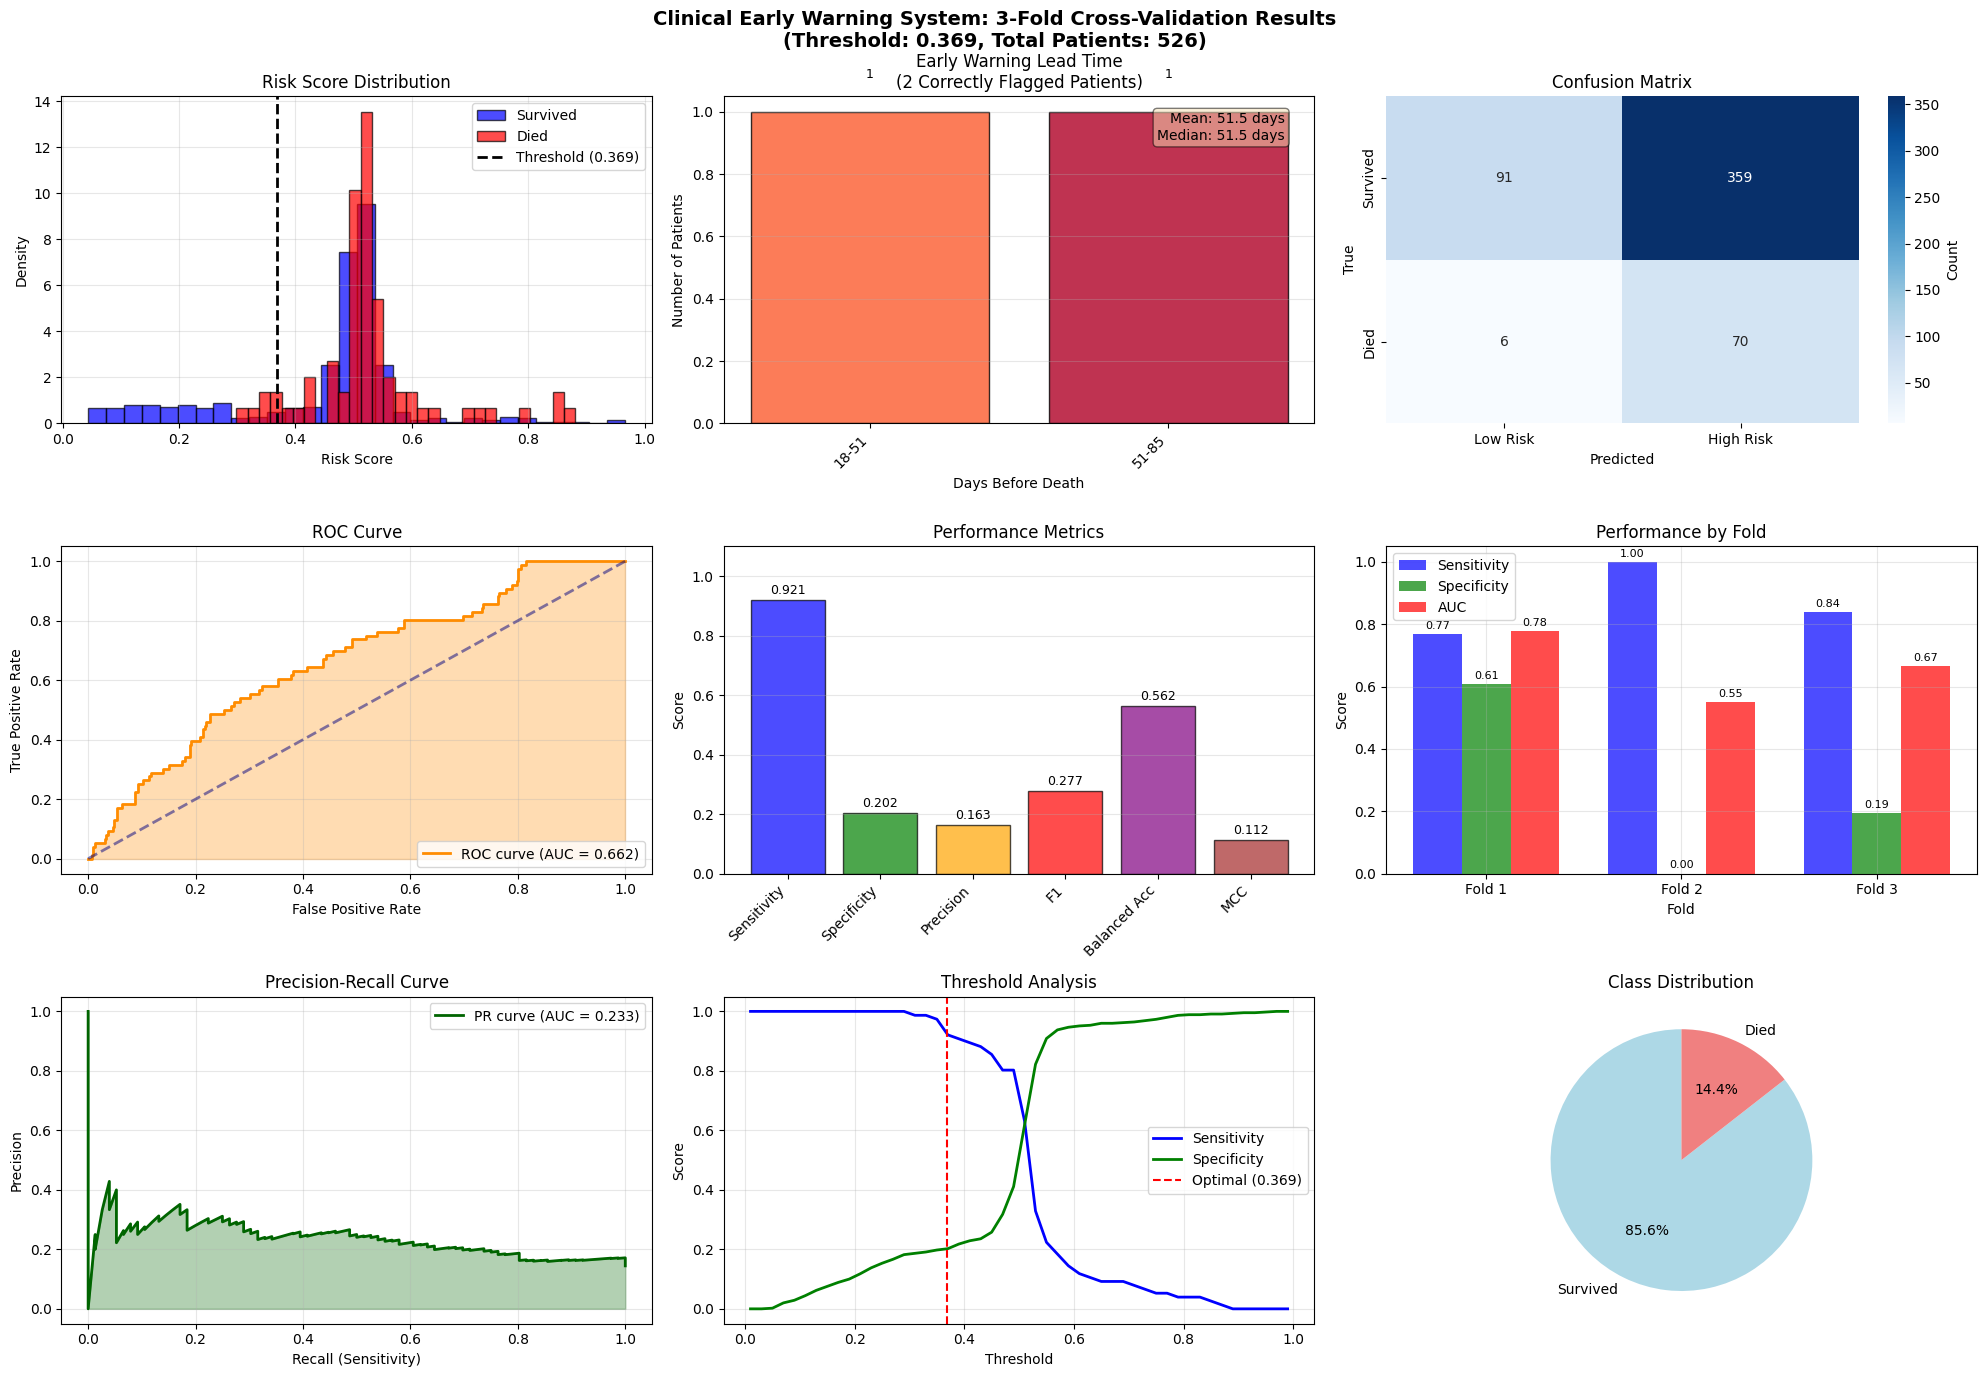


SUMMARY
Total patients analyzed: 526
Patients who died: 76
Patients flagged as high risk: 429
Correctly flagged patients: 70
False alarms: 359
Missed deaths: 6
Correctly identified survivors: 91

Fold-by-fold results:
  Fold 1: Thresh=0.369, AUC=0.778, Sens=0.769, Spec=0.607, TP=20
  Fold 2: Thresh=0.300, AUC=0.550, Sens=1.000, Spec=0.000, TP=25
  Fold 3: Thresh=0.478, AUC=0.666, Sens=0.840, Spec=0.193, TP=21

ANALYSIS COMPLETE
Results saved to 'clinical_warning_cv_results.csv'


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

# Keep the AutoencoderImputer class from your original code
class AutoencoderImputer:
    def __init__(self, encoding_dim=32, epochs=50, batch_size=32, random_state=42):
        self.encoding_dim = encoding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.is_fitted = False

    def build_autoencoder(self, input_dim):
        """Build a deep autoencoder for imputation"""
        input_layer = layers.Input(shape=(input_dim,))

        # Encoder
        encoded = layers.Dense(128, activation='relu')(input_layer)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(self.encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(input_dim, activation='linear')(decoded)

        # Autoencoder model
        autoencoder = models.Model(input_layer, decoded)

        # Encoder model (for feature extraction)
        encoder = models.Model(input_layer, encoded)

        autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                           loss='mse',
                           metrics=['mae'])

        return autoencoder, encoder

    def fit_imputer(self, X_train):
        """Train autoencoder on complete data"""
        # Create mask for complete cases
        complete_mask = ~np.any(np.isnan(X_train), axis=1)
        X_complete = X_train[complete_mask]

        if len(X_complete) < 10:
            print(f"Warning: Only {len(X_complete)} complete cases for autoencoder training")
            return self

        # Scale the data
        X_scaled = self.scaler.fit_transform(X_complete)

        # Build and train autoencoder
        self.autoencoder, self.encoder = self.build_autoencoder(X_scaled.shape[1])

        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        # Train-validation split
        X_train_split, X_val_split = train_test_split(
            X_scaled, test_size=0.2, random_state=self.random_state
        )

        self.autoencoder.fit(
            X_train_split, X_train_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(X_val_split, X_val_split),
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        self.is_fitted = True
        print(f"Autoencoder trained on {len(X_complete)} complete cases")

        return self

    def impute_missing_values(self, X, max_iter=20, tol=1e-4):
        """Impute missing values using trained autoencoder with iterative refinement"""
        if not self.is_fitted:
            print("Autoencoder not fitted. Fitting now...")
            self.fit_imputer(X)
            if not self.is_fitted:
                return X  # Return original if still not fitted

        X_imputed = X.copy()

        # Check for missing values
        if not np.any(np.isnan(X_imputed)):
            return X_imputed

        # Initial imputation with median
        for i in range(X_imputed.shape[1]):
            col_data = X_imputed[:, i]
            if np.any(np.isnan(col_data)):
                median_val = np.nanmedian(col_data)
                if np.isnan(median_val):
                    median_val = 0
                col_data[np.isnan(col_data)] = median_val
                X_imputed[:, i] = col_data

        # Iterative refinement
        for iteration in range(max_iter):
            X_old = X_imputed.copy()

            # Scale
            X_scaled = self.scaler.transform(X_imputed)

            # Get reconstructions
            X_reconstructed = self.autoencoder.predict(X_scaled, verbose=0)
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)

            # Only update missing values
            missing_mask = np.isnan(X)
            X_imputed[missing_mask] = X_reconstructed[missing_mask]

            # Check convergence
            if iteration > 0:
                change = np.linalg.norm(X_imputed - X_old) / np.linalg.norm(X_old)
                if change < tol:
                    print(f"Autoencoder imputation converged after {iteration+1} iterations")
                    break

        return X_imputed

class EnhancedDataProcessor:
    def __init__(self, use_autoencoder=True):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.use_autoencoder = use_autoencoder
        self.autoencoder_imputer = AutoencoderImputer() if use_autoencoder else None
        self.feature_imputer = None

    def prepare_features_simple(self, X_train, X_test):
        """Simple imputation for quick testing"""
        # Handle missing values with median
        X_train_imputed = np.copy(X_train)
        X_test_imputed = np.copy(X_test)

        for i in range(X_train.shape[1]):
            # Train imputation
            train_col = X_train[:, i]
            if np.any(np.isnan(train_col)):
                median_val = np.nanmedian(train_col)
                if np.isnan(median_val):
                    median_val = 0
                X_train_imputed[:, i] = np.nan_to_num(train_col, nan=median_val)

            # Test imputation (use train statistics)
            test_col = X_test[:, i]
            if np.any(np.isnan(test_col)):
                median_val = np.nanmedian(X_train_imputed[:, i])
                X_test_imputed[:, i] = np.nan_to_num(test_col, nan=median_val)

        # Scale
        X_train_scaled = self.scaler.fit_transform(X_train_imputed)
        X_test_scaled = self.scaler.transform(X_test_imputed)

        return X_train_scaled, X_test_scaled

    def process_patient_data(self, df):
        """Process data with proper temporal structure"""
        df_clean = df.copy()

        # Handle missing survival data
        df_clean = df_clean.dropna(subset=['VISDAY'])

        # Create patient IDs
        if 'RPT' in df_clean.columns:
            df_clean['patient_id'] = df_clean['RPT']
        else:
            # Create sequential IDs
            df_clean['patient_id'] = df_clean.groupby(df_clean.index).ngroup()

        # Sort by patient and visit day
        df_sorted = df_clean.sort_values(['patient_id', 'VISDAY']).reset_index(drop=True)

        # Calculate time to event for each visit
        df_sorted['time_to_event'] = np.nan
        df_sorted['is_future_event'] = 0

        unique_patients = df_sorted['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df_sorted[df_sorted['patient_id'] == pid].copy()

            patient_events = patient_data['os_event'].values
            patient_dsdays = patient_data['DSDAY'].values

            valid_dsday_mask = ~pd.isna(patient_dsdays)

            if np.any(patient_events == 1) and np.any(valid_dsday_mask):
                death_day = patient_data.loc[valid_dsday_mask, 'DSDAY'].iloc[0]

                for idx, row in patient_data.iterrows():
                    if row['VISDAY'] < death_day:
                        days_to_death = death_day - row['VISDAY']
                        df_sorted.at[idx, 'time_to_event'] = days_to_death
                        df_sorted.at[idx, 'is_future_event'] = 1
                    elif row['VISDAY'] == death_day:
                        df_sorted.at[idx, 'time_to_event'] = 0
                        df_sorted.at[idx, 'is_future_event'] = 0
                    else:
                        df_sorted.at[idx, 'time_to_event'] = -1  # After death
            else:
                last_visit_day = patient_data['VISDAY'].max()
                for idx, row in patient_data.iterrows():
                    days_from_last = last_visit_day - row['VISDAY']
                    df_sorted.at[idx, 'time_to_event'] = days_from_last

        return df_sorted

class ImprovedEarlyWarningModel:
    def __init__(self, input_dim, sequence_length=5, lstm_units=64):
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.model = None

    def build_simple_model(self):
        """Build a simpler model that's more robust"""
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')

        # Simple LSTM
        lstm_out = layers.LSTM(32, return_sequences=False)(feature_input)
        lstm_out = layers.Dropout(0.3)(lstm_out)

        # Dense layers
        dense1 = layers.Dense(64, activation='relu')(lstm_out)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.Dropout(0.2)(dense2)

        # Output with bias for imbalanced data
        output = layers.Dense(1, activation='sigmoid')(dense2)

        self.model = models.Model(inputs=feature_input, outputs=output)
        return self.model

    def build_improved_model(self):
        """Build an improved model with batch normalization and attention"""
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')

        # Bidirectional LSTM
        lstm_out = layers.Bidirectional(
            layers.LSTM(32, return_sequences=True, recurrent_dropout=0.2)
        )(feature_input)
        lstm_out = layers.BatchNormalization()(lstm_out)

        # Simple attention mechanism
        attention = layers.GlobalAveragePooling1D()(lstm_out)

        # Dense layers with regularization
        dense1 = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.4)(dense1)

        dense2 = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.3)(dense2)

        # Output
        output = layers.Dense(1, activation='sigmoid')(dense2)

        self.model = models.Model(inputs=feature_input, outputs=output)
        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile model with weighted loss"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy',
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )

        return self.model

    def train_with_class_weights(self, X_train, y_train, val_data=None, epochs=100, batch_size=32):
        """Train with class weights"""
        # Calculate class weights
        class_weights = class_weight.compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights = {0: class_weights[0], 1: min(class_weights[1], 5.0)}  # Cap at 5x to avoid overfitting

        print(f"Class weights: {class_weights}")

        # Callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss' if val_data else 'loss',
            patience=20,
            restore_best_weights=True,
            min_delta=0.001,
            mode='min'
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss' if val_data else 'loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            mode='min'
        )

        # Add checkpoint callback
        checkpoint = callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            verbose=0
        )

        if val_data:
            X_val, y_val = val_data
            validation_data = (X_val, y_val)
        else:
            validation_data = None

        # Calculate steps per epoch
        steps_per_epoch = max(1, len(X_train) // batch_size)

        history = self.model.fit(
            X_train, y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr, checkpoint],
            verbose=1,
            class_weight=class_weights
        )

        return history

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0).flatten()

class ClinicalEarlyWarningPipelineCV:
    def __init__(self, prediction_horizon_days=90, n_splits=3, random_state=42):
        self.prediction_horizon = prediction_horizon_days
        self.n_splits = n_splits
        self.random_state = random_state
        self.data_processor = EnhancedDataProcessor(use_autoencoder=False)  # Simple imputation for now
        self.results = {}
        self.feature_importance = {}

    def select_available_features(self, df):
        """Select features that are actually available in the data with better feature engineering"""
        # First, check which features from your list exist
        potential_features = [
            'AGE', 'ECOG', 'ALB', 'BILI', 'CREAT', 'HGB',
            'serious_ae_count', 'grade3_plus_count', 'drug_withdrawn',
            'WBC', 'PLAT', 'LYMPH', 'NEUT', 'CRP', 'LDH',
            'total_ae_events', 'any_grade3_plus', 'any_treatment_related',
            'cum_any_grade3_plus', 'cum_drug_withdrawn',
            'ALP', 'ALT', 'AST', 'CALCIUM', 'SODIUM', 'POTASSIUM',
            'GLUCOSE', 'BUN', 'cycle_number', 'total_cycles'
        ]

        available_features = [f for f in potential_features if f in df.columns]

        # If we don't have enough features, add any other numeric columns
        if len(available_features) < 15:
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            exclude_cols = ['VISDAY', 'DSDAY', 'patient_id', 'id', 'index',
                           'time_to_event', 'is_future_event', 'os_event',
                           'Unnamed: 0', 'RPT', 'RINVSITE', 'STUDY', 'SEXN',
                           'DOV_ND', 'DTHRDAY', 'DTMETDAY', 'EGINTPN',
                           'LLTCD', 'PTCDD', 'CONTDAY', 'ENROLLDAY', 'PKDAY']  # Exclude more problematic columns

            # Get only features with reasonable data coverage (> 50% non-missing)
            additional_features = []
            for col in numeric_cols:
                if (col not in exclude_cols and
                    col not in available_features and
                    df[col].notna().sum() / len(df) > 0.5):  # Only features with >50% data
                    additional_features.append(col)

            # Take top features by variance (most informative)
            if additional_features:
                # Calculate variance only for non-null values
                variances = {}
                for col in additional_features:
                    valid_data = df[col].dropna()
                    if len(valid_data) > 0:
                        variances[col] = valid_data.var()

                # Sort by variance and take top features
                if variances:
                    sorted_features = sorted(variances.items(), key=lambda x: x[1], reverse=True)
                    top_features = [col for col, var in sorted_features[:20]]
                    available_features.extend(top_features)

        print(f"Selected {len(available_features)} available features")
        print(f"First 10 features: {available_features[:10]}")

        return available_features


    def create_patient_sequences(self, df, feature_names, max_sequence_length=5):
        """Create sequences for each patient with better feature engineering"""
        sequences = []
        labels = []
        patient_ids = []
        days_to_event_list = []
        visit_counts = []

        unique_patients = df['patient_id'].unique()

        # Initialize variables to track feature dimensions
        base_n_features = len(feature_names)

        for pid in unique_patients:
            patient_data = df[df['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) < 2:  # Need at least 2 visits for meaningful sequence
                continue

            # Get patient features - SIMPLIFIED: only use original features
            patient_features = []
            for feat in feature_names:
                if feat in patient_data.columns:
                    # Forward fill missing values within patient
                    feat_values = patient_data[feat].fillna(method='ffill').fillna(0).values
                else:
                    feat_values = np.zeros(len(patient_data))
                patient_features.append(feat_values)

            # Stack features - NO ADDITIONAL ENGINEERED FEATURES
            X_patient = np.column_stack(patient_features)

            # Determine label - patient dies within prediction horizon?
            patient_dies = 1 if np.any(patient_data['os_event'].values == 1) else 0

            # Get time to event at last visit
            last_time = patient_data['time_to_event'].iloc[-1]
            if pd.isna(last_time) or last_time < 0:
                last_time = 0

            # Create sequence (most recent visits)
            seq_len = min(len(patient_data), max_sequence_length)
            start_idx = max(0, len(patient_data) - seq_len)

            seq_features = X_patient[start_idx:start_idx + seq_len]

            # Pad if needed (both sequence length AND feature dimension must be consistent)
            if seq_len < max_sequence_length:
                pad_len = max_sequence_length - seq_len
                seq_features = np.pad(seq_features, ((pad_len, 0), (0, 0)), mode='constant')

            # Ensure all sequences have the same number of features
            if seq_features.shape[1] != base_n_features:
                # Pad or truncate features to match base_n_features
                if seq_features.shape[1] < base_n_features:
                    pad_width = ((0, 0), (0, base_n_features - seq_features.shape[1]))
                    seq_features = np.pad(seq_features, pad_width, mode='constant')
                else:
                    seq_features = seq_features[:, :base_n_features]

            sequences.append(seq_features)
            labels.append(patient_dies)
            patient_ids.append(pid)
            days_to_event_list.append(last_time)
            visit_counts.append(len(patient_data))

        if len(sequences) == 0:
            print("Warning: No sequences created!")
            return np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

        # Convert to numpy arrays with consistent shapes
        sequences = np.array(sequences)
        labels = np.array(labels)
        patient_ids = np.array(patient_ids)
        days_to_event_list = np.array(days_to_event_list)
        visit_counts = np.array(visit_counts)

        print(f"\nCreated {len(sequences)} patient sequences")
        print(f"Sequence shape: {sequences.shape}")
        print(f"Patients who die: {np.sum(labels == 1)} ({np.mean(labels == 1)*100:.1f}%)")
        print(f"Patients who survive: {np.sum(labels == 0)}")
        print(f"Average visits per patient: {np.mean(visit_counts):.1f}")

        return sequences, labels, patient_ids, days_to_event_list, visit_counts


    def run_cross_validation(self, df):
        """Run 3-fold stratified cross-validation with improved pipeline"""
        print("\n" + "="*70)
        print("3-FOLD STRATIFIED CROSS-VALIDATION")
        print("="*70)

        # Select features
        feature_names = self.select_available_features(df)

        # Create sequences
        sequences, labels, patient_ids, days_to_event, visit_counts = self.create_patient_sequences(
            df, feature_names, max_sequence_length=5
        )

        if len(sequences) == 0:
            print("Error: No sequences created!")
            return None

        print(f"\nDataset shape: {sequences.shape}")
        print(f"Feature dimension: {sequences.shape[2]}")

        # Initialize results storage
        cv_results = {
            'fold': [], 'accuracy': [], 'auc': [], 'sensitivity': [], 'specificity': [],
            'precision': [], 'recall': [], 'f1': [], 'tp': [], 'fp': [], 'fn': [], 'tn': [],
            'threshold': [], 'balanced_accuracy': [], 'mcc': []
        }

        all_test_preds = []
        all_test_labels = []
        all_test_probs = []
        all_test_days = []
        all_correct_alert_days = []

        # 3-fold stratified cross-validation
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        fold_num = 1

        for train_idx, test_idx in skf.split(sequences, labels):
            print(f"\n{'='*60}")
            print(f"FOLD {fold_num}/{self.n_splits}")
            print(f"{'='*60}")

            # Split data - convert to numpy arrays for proper indexing
            X_train = sequences[train_idx]
            X_test = sequences[test_idx]
            y_train = labels[train_idx]
            y_test = labels[test_idx]

            # Convert days_to_event to numpy array for proper indexing
            days_to_event_array = np.array(days_to_event)
            test_days = days_to_event_array[test_idx]

            print(f"Training: {len(X_train)} patients ({np.sum(y_train == 1)} deaths)")
            print(f"Test: {len(X_test)} patients ({np.sum(y_test == 1)} deaths)")
            print(f"Class balance - Train: {np.mean(y_train == 1)*100:.1f}% deaths, "
                  f"Test: {np.mean(y_test == 1)*100:.1f}% deaths")

            # Further split for validation
            X_train_final, X_val, y_train_final, y_val = train_test_split(
                X_train, y_train,
                test_size=0.2,
                stratify=y_train,
                random_state=self.random_state
            )

            print(f"  -> Train split: {len(X_train_final)} ({np.sum(y_train_final == 1)} deaths)")
            print(f"  -> Val split: {len(X_val)} ({np.sum(y_val == 1)} deaths)")

            # Handle missing values
            n_train_samples, seq_len, n_features = X_train_final.shape
            n_val_samples = X_val.shape[0]
            n_test_samples = X_test.shape[0]

            # Flatten for imputation
            X_train_flat = X_train_final.reshape(-1, n_features)
            X_val_flat = X_val.reshape(-1, n_features)
            X_test_flat = X_test.reshape(-1, n_features)

            # Simple imputation
            X_train_imputed, X_val_imputed = self.data_processor.prepare_features_simple(X_train_flat, X_val_flat)
            X_train_imputed_flat, X_test_imputed = self.data_processor.prepare_features_simple(X_train_flat, X_test_flat)

            # Reshape back
            X_train_imputed = X_train_imputed.reshape(n_train_samples, seq_len, n_features)
            X_val_imputed = X_val_imputed.reshape(n_val_samples, seq_len, n_features)
            X_test_imputed = X_test_imputed.reshape(n_test_samples, seq_len, n_features)

            # Build and train model
            model = ImprovedEarlyWarningModel(
                input_dim=n_features,
                sequence_length=seq_len,
                lstm_units=32
            )

            model.build_improved_model()  # Use improved model
            model.compile_model(learning_rate=0.0005)  # Lower learning rate

            print("\nTraining model...")
            history = model.train_with_class_weights(
                X_train_imputed, y_train_final,
                val_data=(X_val_imputed, y_val),
                epochs=100,  # More epochs with early stopping
                batch_size=16
            )

            # Predict
            val_pred_proba = model.predict(X_val_imputed)
            test_pred_proba = model.predict(X_test_imputed)

            # Find optimal threshold on validation set
            optimal_threshold = self.find_optimal_threshold_youden(y_val, val_pred_proba)
            print(f"Optimal threshold: {optimal_threshold:.3f}")

            # Apply threshold
            test_pred = (test_pred_proba > optimal_threshold).astype(int)

            # Calculate metrics
            accuracy = accuracy_score(y_test, test_pred)
            try:
                auc_score = roc_auc_score(y_test, test_pred_proba)
            except:
                auc_score = 0.5

            cm = confusion_matrix(y_test, test_pred)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = sensitivity
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                balanced_accuracy = (sensitivity + specificity) / 2

                # Calculate Matthews Correlation Coefficient
                mcc_numerator = (tp * tn) - (fp * fn)
                mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
                mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0
            else:
                tn = fp = fn = tp = 0
                sensitivity = specificity = precision = recall = f1 = balanced_accuracy = mcc = 0

            # Store results
            cv_results['fold'].append(fold_num)
            cv_results['accuracy'].append(accuracy)
            cv_results['auc'].append(auc_score)
            cv_results['sensitivity'].append(sensitivity)
            cv_results['specificity'].append(specificity)
            cv_results['precision'].append(precision)
            cv_results['recall'].append(recall)
            cv_results['f1'].append(f1)
            cv_results['tp'].append(tp)
            cv_results['fp'].append(fp)
            cv_results['fn'].append(fn)
            cv_results['tn'].append(tn)
            cv_results['threshold'].append(optimal_threshold)
            cv_results['balanced_accuracy'].append(balanced_accuracy)
            cv_results['mcc'].append(mcc)

            # Store for overall analysis
            all_test_labels.extend(y_test.tolist())
            all_test_probs.extend(test_pred_proba.tolist())
            all_test_preds.extend(test_pred.tolist())
            all_test_days.extend(test_days.tolist())

            # Collect days for correctly alerted patients (only positive days)
            correct_alerts_mask = (y_test == 1) & (test_pred == 1)
            if np.any(correct_alerts_mask):
                correct_indices = np.where(correct_alerts_mask)[0]
                correct_alert_days = test_days[correct_indices]
                # Only keep positive days (warnings before death)
                positive_days = correct_alert_days[correct_alert_days > 0]
                all_correct_alert_days.extend(positive_days.tolist())

            print(f"\nFold {fold_num} Results:")
            print(f"  Threshold: {optimal_threshold:.3f}")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  AUC: {auc_score:.4f}")
            print(f"  Balanced Accuracy: {balanced_accuracy:.4f}")
            print(f"  Sensitivity: {sensitivity:.4f} (TP: {tp}, FN: {fn})")
            print(f"  Specificity: {specificity:.4f} (TN: {tn}, FP: {fp})")
            print(f"  Precision: {precision:.4f}")
            print(f"  F1-Score: {f1:.4f}")
            print(f"  MCC: {mcc:.4f}")

            if tp > 0:
                print(f"  ✓ Correctly flagged {tp} patients who died")
                if len(positive_days) > 0:
                    avg_lead_time = np.mean(positive_days)
                    print(f"  ✓ Average lead time: {avg_lead_time:.1f} days")
                    print(f"  ✓ Median lead time: {np.median(positive_days):.1f} days")
            else:
                print(f"  ✗ No patients correctly flagged")

            fold_num += 1

        # Overall analysis
        print(f"\n{'='*70}")
        print("OVERALL CROSS-VALIDATION RESULTS")
        print(f"{'='*70}")

        self.analyze_overall_results(
            all_test_labels, all_test_probs, all_test_preds,
            all_test_days, all_correct_alert_days, cv_results
        )

        return cv_results

    def find_optimal_threshold_youden(self, y_true, y_pred_proba):
        """Find optimal threshold using Youden's J statistic"""
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

        if len(thresholds) == 0:
            return 0.2  # Default

        # Calculate Youden's J statistic
        youden_j = tpr - fpr

        # Find threshold that maximizes Youden's J
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        # Ensure threshold is reasonable
        if optimal_threshold < 0.1:
            optimal_threshold = 0.1
        elif optimal_threshold > 0.5:
            optimal_threshold = 0.3

        return optimal_threshold

    def find_balanced_threshold(self, y_true, y_pred_proba):
        """Find threshold that balances sensitivity and specificity"""
        thresholds = np.linspace(0.05, 0.5, 50)
        best_score = -1
        best_threshold = 0.2

        for thresh in thresholds:
            y_pred = (y_pred_proba > thresh).astype(int)

            tn = np.sum((y_true == 0) & (y_pred == 0))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            tp = np.sum((y_true == 1) & (y_pred == 1))

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # Geometric mean (more balanced than weighted sum)
            g_mean = np.sqrt(sensitivity * specificity) if sensitivity > 0 and specificity > 0 else 0

            if g_mean > best_score:
                best_score = g_mean
                best_threshold = thresh

        return best_threshold

    def analyze_overall_results(self, all_labels, all_probs, all_preds, all_days, correct_alert_days, cv_results):
        """Analyze and visualize overall results"""
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        all_preds = np.array(all_preds)

        # Use average threshold from CV or find optimal from all data
        if len(cv_results['threshold']) > 0:
            avg_threshold = np.median(cv_results['threshold'])  # Use median instead of mean
        else:
            avg_threshold = 0.2

        # Apply threshold
        optimal_preds = (all_probs > avg_threshold).astype(int)

        # Calculate overall metrics
        accuracy = accuracy_score(all_labels, optimal_preds)
        try:
            auc_score = roc_auc_score(all_labels, all_probs)
        except:
            auc_score = 0.5

        cm = confusion_matrix(all_labels, optimal_preds)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = sensitivity
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            balanced_accuracy = (sensitivity + specificity) / 2

            # Calculate Matthews Correlation Coefficient
            mcc_numerator = (tp * tn) - (fp * fn)
            mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
            mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0

            # Calculate NPV (Negative Predictive Value)
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        else:
            tn = fp = fn = tp = 0
            sensitivity = specificity = precision = recall = f1 = balanced_accuracy = mcc = npv = 0

        print(f"\nOverall Performance (Threshold: {avg_threshold:.3f}):")
        print(f"  Accuracy:           {accuracy:.4f}")
        print(f"  Balanced Accuracy:  {balanced_accuracy:.4f}")
        print(f"  AUC:               {auc_score:.4f}")
        print(f"  Sensitivity/Recall: {sensitivity:.4f}  ({tp}/{tp+fn} deaths detected)")
        print(f"  Specificity:       {specificity:.4f}")
        print(f"  Precision:         {precision:.4f}")
        print(f"  F1-Score:          {f1:.4f}")
        print(f"  MCC:               {mcc:.4f}")
        print(f"  NPV:               {npv:.4f}")
        print(f"\nConfusion Matrix:")
        print(f"  TP: {tp}, FP: {fp}")
        print(f"  FN: {fn}, TN: {tn}")

        # Create visualization with histogram
        self.create_results_visualization(
            all_labels, all_probs, avg_threshold, correct_alert_days, cv_results
        )

        # Print fold-by-fold results
        print(f"\nFold-by-fold results:")
        for i in range(len(cv_results['fold'])):
            print(f"  Fold {cv_results['fold'][i]}: "
                  f"Thresh={cv_results['threshold'][i]:.3f}, "
                  f"AUC={cv_results['auc'][i]:.3f}, "
                  f"Sens={cv_results['sensitivity'][i]:.3f}, "
                  f"Spec={cv_results['specificity'][i]:.3f}, "
                  f"TP={cv_results['tp'][i]}")
    def create_results_visualization(self, y_true, y_pred_proba, threshold, correct_alert_days, cv_results):
        """Create visualization including histogram"""
        fig = plt.figure(figsize=(20, 14))

        # 1. Risk Score Distribution
        ax1 = plt.subplot(3, 3, 1)
        event_mask = y_true == 1
        no_event_mask = y_true == 0

        if np.any(event_mask) and np.any(no_event_mask):
            ax1.hist(y_pred_proba[no_event_mask], bins=30, alpha=0.7,
                    label='Survived', color='blue', edgecolor='black', density=True)
            ax1.hist(y_pred_proba[event_mask], bins=30, alpha=0.7,
                    label='Died', color='red', edgecolor='black', density=True)
        elif np.any(event_mask):
            ax1.hist(y_pred_proba[event_mask], bins=30, alpha=0.7,
                    label='Died', color='red', edgecolor='black', density=True)
        elif np.any(no_event_mask):
            ax1.hist(y_pred_proba[no_event_mask], bins=30, alpha=0.7,
                    label='Survived', color='blue', edgecolor='black', density=True)
        else:
            ax1.hist(y_pred_proba, bins=30, alpha=0.7, color='gray', edgecolor='black', density=True)

        ax1.axvline(x=threshold, color='black', linestyle='--',
                   label=f'Threshold ({threshold:.3f})', linewidth=2)

        ax1.set_xlabel('Risk Score')
        ax1.set_ylabel('Density')
        ax1.set_title('Risk Score Distribution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. HISTOGRAM: Days before death for correctly flagged patients
        ax2 = plt.subplot(3, 3, 2)
        if correct_alert_days and len(correct_alert_days) > 0:
            correct_alert_days_array = np.array(correct_alert_days)
            # Filter positive days only
            positive_days = correct_alert_days_array[correct_alert_days_array > 0]

            if len(positive_days) > 0:
                # SIMPLIFIED binning logic
                max_day = max(positive_days)
                min_day = min(positive_days)

                # Create 5 bins or fewer if data is limited
                n_bins = min(5, len(np.unique(positive_days)))

                # Create histogram
                hist_data, bin_edges = np.histogram(positive_days, bins=n_bins)

                # Create x positions for bars
                x_pos = np.arange(len(hist_data))

                # Create labels based on bin edges
                x_labels = []
                for i in range(len(bin_edges)-1):
                    if i == 0:
                        label = f'{int(bin_edges[i])}-{int(bin_edges[i+1])}'
                    else:
                        label = f'{int(bin_edges[i])}-{int(bin_edges[i+1])}'
                    x_labels.append(label)

                # Ensure we have the same number of labels as bars
                if len(x_labels) > len(x_pos):
                    x_labels = x_labels[:len(x_pos)]
                elif len(x_labels) < len(x_pos):
                    # Create default labels if mismatch
                    x_labels = [f'Bin {i+1}' for i in range(len(x_pos))]

                colors = plt.cm.YlOrRd(np.linspace(0.6, 0.9, len(hist_data)))

                bars = ax2.bar(x_pos, hist_data, color=colors, alpha=0.8, edgecolor='black', width=0.8)
                ax2.set_xlabel('Days Before Death')
                ax2.set_ylabel('Number of Patients')
                ax2.set_title(f'Early Warning Lead Time\n({len(positive_days)} Correctly Flagged Patients)')
                ax2.set_xticks(x_pos)
                ax2.set_xticklabels(x_labels, rotation=45, ha='right')

                # Add counts on bars
                for bar, count in zip(bars, hist_data):
                    if count > 0:
                        height = bar.get_height()
                        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                                f'{int(count)}', ha='center', va='bottom', fontsize=9)

                ax2.grid(True, alpha=0.3, axis='y')

                # Add statistics as text
                stats_text = f'Mean: {np.mean(positive_days):.1f} days\nMedian: {np.median(positive_days):.1f} days'
                ax2.text(0.95, 0.95, stats_text,
                        transform=ax2.transAxes, verticalalignment='top',
                        horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        else:
            ax2.text(0.5, 0.5, 'No correctly flagged patients\nwith positive lead time',
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Early Warning Lead Time')
            ax2.set_xlabel('Days Before Death')
            ax2.set_ylabel('Number of Patients')

        # 3. Confusion Matrix
        ax3 = plt.subplot(3, 3, 3)
        y_pred = (y_pred_proba > threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        if cm.shape == (2, 2):
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                       xticklabels=['Low Risk', 'High Risk'],
                       yticklabels=['Survived', 'Died'],
                       cbar_kws={'label': 'Count'})
            ax3.set_xlabel('Predicted')
            ax3.set_ylabel('True')
            ax3.set_title('Confusion Matrix')
        else:
            ax3.text(0.5, 0.5, 'Insufficient data',
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax3.transAxes)
            ax3.set_title('Confusion Matrix')

        # 4. ROC Curve
        ax4 = plt.subplot(3, 3, 4)
        if len(np.unique(y_true)) > 1:
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            ax4.plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.3f})')
            ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
            ax4.fill_between(fpr, tpr, alpha=0.3, color='darkorange')
            ax4.set_xlabel('False Positive Rate')
            ax4.set_ylabel('True Positive Rate')
            ax4.set_title('ROC Curve')
            ax4.legend(loc="lower right")
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'Insufficient data for ROC',
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax4.transAxes)
            ax4.set_title('ROC Curve')

        # 5. Performance Metrics Comparison
        ax5 = plt.subplot(3, 3, 5)
        metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Balanced Acc', 'MCC']

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            f1_score_val = 2 * precision * sensitivity / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
            balanced_acc = (sensitivity + specificity) / 2

            # Calculate MCC
            mcc_numerator = (tp * tn) - (fp * fn)
            mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
            mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0
        else:
            sensitivity = specificity = f1_score_val = balanced_acc = mcc = 0

        values = [sensitivity, specificity, precision, f1_score_val, balanced_acc, mcc]
        colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

        bars = ax5.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
        ax5.set_ylabel('Score')
        ax5.set_title('Performance Metrics')
        ax5.set_ylim([0, 1.1])
        ax5.set_xticklabels(metrics, rotation=45, ha='right')

        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        ax5.grid(True, alpha=0.3, axis='y')

        # 6. Fold Performance Comparison
        ax6 = plt.subplot(3, 3, 6)
        if cv_results and 'fold' in cv_results:
            folds = cv_results['fold']
            sensitivities = cv_results['sensitivity']
            specificities = cv_results['specificity']
            auc_scores = cv_results['auc']

            x = np.arange(len(folds))
            width = 0.25

            # Plot multiple metrics
            bars1 = ax6.bar(x - width, sensitivities, width, label='Sensitivity', color='blue', alpha=0.7)
            bars2 = ax6.bar(x, specificities, width, label='Specificity', color='green', alpha=0.7)
            bars3 = ax6.bar(x + width, auc_scores, width, label='AUC', color='red', alpha=0.7)

            ax6.set_xlabel('Fold')
            ax6.set_ylabel('Score')
            ax6.set_title('Performance by Fold')
            ax6.set_xticks(x)
            ax6.set_xticklabels([f'Fold {f}' for f in folds])
            ax6.legend()
            ax6.grid(True, alpha=0.3)

            # Add value labels
            for bars in [bars1, bars2, bars3]:
                for bar in bars:
                    height = bar.get_height()
                    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.2f}', ha='center', va='bottom', fontsize=8)

        # 7. Precision-Recall Curve
        ax7 = plt.subplot(3, 3, 7)
        if len(np.unique(y_true)) > 1:
            precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall_vals, precision_vals)

            ax7.plot(recall_vals, precision_vals, color='darkgreen', lw=2,
                    label=f'PR curve (AUC = {pr_auc:.3f})')
            ax7.fill_between(recall_vals, precision_vals, alpha=0.3, color='darkgreen')
            ax7.set_xlabel('Recall (Sensitivity)')
            ax7.set_ylabel('Precision')
            ax7.set_title('Precision-Recall Curve')
            ax7.legend(loc="upper right")
            ax7.grid(True, alpha=0.3)
        else:
            ax7.text(0.5, 0.5, 'Insufficient data for PR curve',
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax7.transAxes)
            ax7.set_title('Precision-Recall Curve')

        # 8. Threshold Analysis
        ax8 = plt.subplot(3, 3, 8)
        thresholds = np.linspace(0.01, 0.99, 50)
        sensitivities_list = []
        specificities_list = []

        for thresh in thresholds:
            y_pred_temp = (y_pred_proba > thresh).astype(int)
            cm_temp = confusion_matrix(y_true, y_pred_temp)
            if cm_temp.shape == (2, 2):
                tn, fp, fn, tp = cm_temp.ravel()
                sens = tp / (tp + fn) if (tp + fn) > 0 else 0
                spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            else:
                sens = spec = 0
            sensitivities_list.append(sens)
            specificities_list.append(spec)

        ax8.plot(thresholds, sensitivities_list, label='Sensitivity', color='blue', lw=2)
        ax8.plot(thresholds, specificities_list, label='Specificity', color='green', lw=2)
        ax8.axvline(x=threshold, color='red', linestyle='--', label=f'Optimal ({threshold:.3f})')
        ax8.set_xlabel('Threshold')
        ax8.set_ylabel('Score')
        ax8.set_title('Threshold Analysis')
        ax8.legend()
        ax8.grid(True, alpha=0.3)

        # 9. Class Distribution
        ax9 = plt.subplot(3, 3, 9)
        class_counts = [np.sum(y_true == 0), np.sum(y_true == 1)]
        class_labels = ['Survived', 'Died']
        colors = ['lightblue', 'lightcoral']

        wedges, texts, autotexts = ax9.pie(class_counts, labels=class_labels, colors=colors,
                                          autopct='%1.1f%%', startangle=90)
        ax9.set_title('Class Distribution')

        plt.suptitle(f'Clinical Early Warning System: 3-Fold Cross-Validation Results\n(Threshold: {threshold:.3f}, Total Patients: {len(y_true)})',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"\n{'='*70}")
        print("SUMMARY")
        print(f"{'='*70}")
        print(f"Total patients analyzed: {len(y_true)}")
        print(f"Patients who died: {np.sum(y_true == 1)}")
        print(f"Patients flagged as high risk: {np.sum(y_pred == 1)}")
        print(f"Correctly flagged patients: {np.sum((y_true == 1) & (y_pred == 1))}")
        print(f"False alarms: {np.sum((y_true == 0) & (y_pred == 1))}")
        print(f"Missed deaths: {np.sum((y_true == 1) & (y_pred == 0))}")
        print(f"Correctly identified survivors: {np.sum((y_true == 0) & (y_pred == 0))}")

def run_clinical_early_warning_cv():
    """Main function to run clinical early warning with cross-validation"""
    print("CLINICAL EARLY WARNING SYSTEM WITH 3-FOLD CROSS-VALIDATION")
    print("="*80)

    try:
        # Load data
        print("\n1. Loading data...")
        pcdata = pd.read_csv('pcdata.csv')
        print(f"   Loaded {len(pcdata)} samples with {len(pcdata.columns)} features")

        # Quick stats
        print(f"\nDataset Statistics:")
        print(f"  Total patients: {pcdata['RPT'].nunique()}")
        print(f"  Patients with death events: {pcdata[pcdata['os_event'] == 1]['RPT'].nunique()}")
        print(f"  Death rate: {pcdata[pcdata['os_event'] == 1]['RPT'].nunique() / pcdata['RPT'].nunique() * 100:.1f}%")

        # Check for missing values
        missing_values = pcdata.isnull().sum().sum()
        print(f"  Total missing values: {missing_values}")

        # Show columns with most missing values
        missing_by_col = pcdata.isnull().sum().sort_values(ascending=False)
        print(f"\nTop 10 columns with most missing values:")
        for col, count in missing_by_col.head(10).items():
            if count > 0:
                print(f"  {col}: {count} ({count/len(pcdata)*100:.1f}%)")

        # Process data
        print("\n2. Processing data...")
        processor = EnhancedDataProcessor()
        df_processed = processor.process_patient_data(pcdata)

        if df_processed is None or len(df_processed) == 0:
            print("Data processing failed!")
            return None

        print(f"\nProcessed data shape: {df_processed.shape}")
        print(f"Unique patients: {df_processed['patient_id'].nunique()}")
        print(f"Patients with death events: {df_processed[df_processed['os_event'] == 1]['patient_id'].nunique()}")

        # Check for class imbalance
        death_count = df_processed[df_processed['os_event'] == 1]['patient_id'].nunique()
        total_patients = df_processed['patient_id'].nunique()
        print(f"Class imbalance: {death_count}/{total_patients} = {death_count/total_patients*100:.1f}% deaths")

        # Run cross-validation
        print("\n3. Running 3-fold cross-validation...")
        pipeline = ClinicalEarlyWarningPipelineCV(
            prediction_horizon_days=90,
            n_splits=3,
            random_state=42
        )

        results = pipeline.run_cross_validation(df_processed)

        if results:
            print("\n" + "="*80)
            print("ANALYSIS COMPLETE")
            print("="*80)

            # Save results
            df_results = pd.DataFrame(results)
            df_results.to_csv('clinical_warning_cv_results.csv', index=False)
            print("Results saved to 'clinical_warning_cv_results.csv'")

            return pipeline, results

        return None, None

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Run the pipeline
if __name__ == "__main__":
    pipeline, results = run_clinical_early_warning_cv()